In [ ]:
import json
from google.colab import drive
drive.mount('/content/drive')

file_path="/content/drive/MyDrive/attiki odos/Τροχαία ατυχήματα ΑΟ 2014_2024.xlsx"


file_path_geojson = '/content/drive/MyDrive/attiki odos/attiki_merged_6666666.geojson'

try:
    with open(file_path_geojson, 'r') as f:
        data = json.load(f)
    print("File loaded successfully using json!")
    print(f"First feature: {data['features'][0]}") # Print the first feature to verify
except FileNotFoundError:
    print(f"Error: File not found at '{file_path}'. Double-check the path.")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from '{file_path}'. Check if the file is valid JSON.")
except Exception as e:
    print(f"An error occurred: {e}")


Mounted at /content/drive
File loaded successfully using json!
First feature: {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [23.87263387441635, 37.996259910790045]}, 'properties': {'_label_class': 0, '_name': 'E 37.1'}}


## aggregate injuries and deaths

In [ ]:
import pandas as pd
import json
from collections import defaultdict

# Load the dataset
df_injuries = pd.read_excel(file_path, sheet_name="Με τραυματισμό")  # or "Θανατηφόρα"
df_deaths = pd.read_excel(file_path, sheet_name="Θανατηφόρα")  # or "Θανατηφόρα"

# Add label for type
df_injuries["accident_type"] = "injury"
df_deaths["accident_type"] = "death"

# Combine into one big dataset
df = pd.concat([df_injuries, df_deaths], ignore_index=True)
df.columns = df.columns.str.strip().str.replace('\n', '_').str.replace(' ', '_')

## extract mileposts

In [ ]:
simplified = []

for feature in data["features"]:
    props = feature["properties"]

    # Try checking _name first, if not fallback to _name1, _name2, _name3
    name = (
        props.get("_name") or
        props.get("_name1") or
        props.get("_name2") or
        props.get("_name3") or
        props.get("_name4")
    )

    if not name or " " not in name:
        continue

    # Split into segment and km
    parts = name.split(" ", 1)
    if len(parts) == 2:
        segment, km_str = parts
        try:
            km = float(km_str.replace(',', '.').strip('()'))  # replace comma with dot if needed
        except ValueError:
            continue

        lng, lat = feature["geometry"]["coordinates"]
        simplified.append({
            "segment": segment,
            "km": km,
            "lat": lat,
            "lng": lng
        })

print(f"✅ Saved {len(simplified)} milepost entries ")

✅ Saved 2738 milepost entries 


In [ ]:
# First create empty columns
df["lat"] = None
df["lng"] = None

for idx, (segment, km) in enumerate(df[["ΑΥΤ/ΔΡΟΜΟΣ", "ΧΙΛ.ΘΕΣΗ"]].itertuples(index=False, name=None)):
    found = False
    for item in simplified:
        if item["segment"] == segment and abs(item["km"] - km) < 0.01:
            df.at[idx, "lat"] = item["lat"]
            df.at[idx, "lng"] = item["lng"]
            found = True
            break

    if not found:
        # Try nearby kms
        for delta in [0.1, -0.1, 0.2, -0.2]:
            for item in simplified:
                if item["segment"] == segment and abs(item["km"] - (km + delta)) < 0.01:
                    df.at[idx, "lat"] = item["lat"]
                    df.at[idx, "lng"] = item["lng"]
                    found = True
                    print(f"Inferred coordinates for segment {segment} and km {km} from nearby km {item['km']}")
                    break
            if found:
                break

    if not found:
        print(f"Still could not find coordinates for segment {segment} and km {km}")

Still could not find coordinates for segment Z and km 0.0
Still could not find coordinates for segment B and km 0.0
Still could not find coordinates for segment X and km 0.0
Still could not find coordinates for segment P and km 0.0
Inferred coordinates for segment B and km 5.3 from nearby km 5.4


In [ ]:
# Drop rows where lat is None
df.dropna(subset=["lat"], inplace=True)

print(f"Dropped rows without inferred coordinates. Remaining rows: {len(df)}")

Dropped rows without inferred coordinates. Remaining rows: 523


## foramt the involved vehicle cols

In [ ]:
# Step 1: Rename the vehicle columns
vehicle_cols = {
    'ΕΜΠΛΕΚΟΜΕΝΑ_ΟΧΗΜΑΤΑ': 'involved_vehicle_1',
    'Unnamed:_17': 'involved_vehicle_2',
    'Unnamed:_18': 'involved_vehicle_3',
    'Unnamed:_19': 'involved_vehicle_4',
    'Unnamed:_20': 'involved_vehicle_5',
    'Unnamed:_21': 'involved_vehicle_6',
    'Unnamed:_22': 'involved_vehicle_7',
}

df = df.rename(columns=vehicle_cols)


# Step 2: Standardize values across all involved vehicle columns
involved_cols = [f'involved_vehicle_{i}' for i in range(1, 8)]

def clean_vehicle(v):
    if pd.isna(v): return None
    return v.strip().upper()

for col in involved_cols:
    df[col] = df[col].apply(clean_vehicle)



# Step 3: Feature engineering
vehicle_types = ['ΙΧΕ', 'ΚΡΑΤΙΚΟ ΟΧΗΜΑ', 'ΔΙΚΥΚΛΟ', 'ΦΟΡΤΗΓΟ', 'ΤΑΞΙ', 'ΛΕΩΦΟΡΕΙΟ', 'Μ.Ε.']

# Count of involved vehicles
df['num_involved_vehicles'] = df[involved_cols].notna().sum(axis=1)

# Boolean flags for each type
for v_type in vehicle_types:
    df[f'has_{v_type}'] = df[involved_cols].apply(lambda row: v_type in row.values, axis=1)

# TODO: maybe drop involved_vehicle_x

## get weather data

In [ ]:
import requests
import pandas as pd
from tqdm import tqdm
from datetime import datetime

# Ensure 'ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ' is datetime
if not pd.api.types.is_datetime64_any_dtype(df["ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ"]):
    df["ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ"] = pd.to_datetime(df["ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ"])

# Columns to store - added weather_code and is_day
weather_columns = [
    "temperature_2m", "relative_humidity_2m", "pressure_msl", "visibility",
    "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m", "precipitation",
    "weather_code", "is_day" # Added valuable features
]

# Add empty columns using pd.NA
for col in weather_columns:
    df[col] = pd.NA

# Loop through each row and query the API
for idx, row in tqdm(df.iterrows(), total=len(df)):
    lat = row["lat"]
    lon = row["lng"]
    timestamp = row["ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ"]

    if pd.isna(lat) or pd.isna(lon) or pd.isna(timestamp):
        print(f"⚠️ Missing essential data at index {idx} (Lat: {lat}, Lon: {lon}, Timestamp: {timestamp}). Skipping weather fetch.")
        continue

    date_str = timestamp.strftime('%Y-%m-%d')
    target_time_iso = f"{date_str}T{timestamp.strftime('%H:00')}" # Full ISO time for matching

    try:
        url = (
            f"https://archive-api.open-meteo.com/v1/archive?"
            f"latitude={lat:.4f}&longitude={lon:.4f}" # Format lat/lon for cleanliness
            f"&start_date={date_str}&end_date={date_str}"
            f"&hourly=temperature_2m,relative_humidity_2m,pressure_msl,visibility,"
            f"wind_speed_10m,wind_direction_10m,wind_gusts_10m,precipitation,weather_code,is_day" # Added new params
            f"&timezone=auto"
        )

        try:
            res = requests.get(url, timeout=20) # Increased timeout
            res.raise_for_status() # Raise an exception for HTTP errors (4xx or 5xx)
            data = res.json()

            if "hourly" in data and "time" in data["hourly"]:
                time_list = data["hourly"]["time"]

                try:
                    time_idx = time_list.index(target_time_iso)

                    for col_name in weather_columns:
                        if col_name in data["hourly"]:
                            value = data["hourly"][col_name][time_idx]
                            # API might return null (None in JSON) for some values (e.g., precipitation)
                            df.at[idx, col_name] = value if value is not None else pd.NA
                        else:
                            print(f"📢 API response for index {idx} did not contain key: {col_name}")
                            df.at[idx, col_name] = pd.NA

                except ValueError:
                    print(f"🔎 Target time {target_time_iso} not found in API response's time_list for index {idx}. Weather data set to NA.")
                    for col_name in weather_columns: df.at[idx, col_name] = pd.NA
            else:
                print(f"📉 'hourly' data or 'time' array not in API response for index {idx}. Weather data set to NA.")
                for col_name in weather_columns: df.at[idx, col_name] = pd.NA

        except requests.exceptions.Timeout:
            print(f"⏱️ Timeout for API request at index {idx}. Weather data set to NA.")
            for col_name in weather_columns: df.at[idx, col_name] = pd.NA
        except requests.exceptions.HTTPError as http_err:
            print(f"🚫 HTTP error for API request at index {idx}: {http_err}. Weather data set to NA.")
            for col_name in weather_columns: df.at[idx, col_name] = pd.NA
        except requests.exceptions.RequestException as req_err: # Catch other request-related errors
            print(f"🔗 Request error for API request at index {idx}: {req_err}. Weather data set to NA.")
            for col_name in weather_columns: df.at[idx, col_name] = pd.NA
        except Exception as e: # Catch JSON parsing errors or other unexpected issues
            print(f"❌ Error processing data for index {idx} (URL: {url}): {e}. Weather data set to NA.")
            for col_name in weather_columns: df.at[idx, col_name] = pd.NA

    except Exception as e: # Catch errors from building the URL or other pre-request issues
        print(f"❌ Outer error before API call for index {idx}: {e}")
        for col_name in weather_columns: df.at[idx, col_name] = pd.NA

# Now df should have the new weather columns populated
# Example: df.to_csv("accidents_with_weather_enhanced.csv", index=False)
print(df[weather_columns].info())
print(df[weather_columns].head())

 58%|█████▊    | 303/523 [03:29<24:11,  6.60s/it]

⏱️ Timeout for API request at index 305. Weather data set to NA.


 58%|█████▊    | 304/523 [03:49<39:15, 10.76s/it]

⏱️ Timeout for API request at index 306. Weather data set to NA.


 92%|█████████▏| 482/523 [06:28<04:25,  6.48s/it]

⏱️ Timeout for API request at index 485. Weather data set to NA.


100%|██████████| 523/523 [06:56<00:00,  1.26it/s]

<class 'pandas.core.frame.DataFrame'>
Index: 523 entries, 0 to 526
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   temperature_2m        520 non-null    object
 1   relative_humidity_2m  520 non-null    object
 2   pressure_msl          520 non-null    object
 3   visibility            0 non-null      object
 4   wind_speed_10m        520 non-null    object
 5   wind_direction_10m    520 non-null    object
 6   wind_gusts_10m        520 non-null    object
 7   precipitation         520 non-null    object
 8   weather_code          520 non-null    object
 9   is_day                520 non-null    object
dtypes: object(10)
memory usage: 61.1+ KB
None
  temperature_2m relative_humidity_2m pressure_msl visibility wind_speed_10m  \
0            9.5                   80       1019.8       <NA>           11.4   
1            6.1                   97       1020.0       <NA>            8.3   
2           1

## checking that all the weather columns got filled

In [ ]:
# Select only the rows that had missing temperature or weather_code initially
# We'll iterate through these and attempt to fill any missing weather data in the original df
missing_rows_indices = df[df['temperature_2m'].isna() | df['weather_code'].isna()].index

import requests
from datetime import datetime
import pandas as pd # Ensure pandas is imported for pd.NA

print("Attempting to re-fetch and add data for rows with initial missing weather information:")

# List of all weather columns we want to check and potentially update
weather_columns_to_update = [
    "temperature_2m",
    "relative_humidity_2m",
    "pressure_msl",
    "visibility", # Included visibility as it was in the initial fetch list
    "wind_speed_10m",
    "wind_direction_10m",
    "wind_gusts_10m",
    "precipitation",
    "weather_code",
    "is_day"
]

for idx in missing_rows_indices:
    # Get the row data directly from the original df using the index
    row = df.loc[idx]

    lat = row["lat"]
    lon = row["lng"]
    timestamp = row["ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ"] # Assuming this column holds the datetime

    # Check if essential data for the API call is available
    if pd.isna(lat) or pd.isna(lon) or pd.isna(timestamp):
        print(f"⚠️ Cannot re-fetch for index {idx}: Missing Lat, Lon, or Timestamp in the row.")
        continue # Skip this row if we can't even form the API request

    date_str = timestamp.strftime('%Y-%m-%d')
    target_time_iso = f"{date_str}T{timestamp.strftime('%H:00')}" # Ensure we query for the correct hour

    print(f"\n--- Re-fetching data for index {idx} ---")
    print(f"Lat: {lat}, Lon: {lon}, Date: {date_str}, Time: {target_time_iso}")

    try:
        # Construct the API URL, requesting all the relevant hourly parameters
        url = (
            f"https://archive-api.open-meteo.com/v1/archive?"
            f"latitude={lat:.4f}&longitude={lon:.4f}"
            f"&start_date={date_str}&end_date={date_str}"
            f"&hourly={','.join(weather_columns_to_update)}" # Request all columns in the list
            f"&timezone=auto"
        )

        # print(f"Query URL: {url}") # You can uncomment this if you want to see the URL

        res = requests.get(url, timeout=20)
        res.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)
        data = res.json()

        # Check if the response structure is as expected
        if "hourly" in data and "time" in data["hourly"]:
            time_list = data["hourly"]["time"]

            try:
                # Find the index corresponding to the exact hour of the accident
                time_idx = time_list.index(target_time_iso)

                # Loop through the columns we want to update and fetch their values
                for col_name in weather_columns_to_update:
                    # Check if the column exists in the API response's 'hourly' data
                    if col_name in data["hourly"]:
                        # Get the value at the found time index
                        value = data["hourly"][col_name][time_idx]

                        # Update the df only if the fetched value is not None (or not a pandas NA value)
                        # and the current value in the df is actually missing.
                        # This prevents overwriting potentially manually corrected data
                        # and ensures we only fill initially missing spots.
                        current_df_value = df.at[idx, col_name]
                        if pd.isna(current_df_value) and value is not None:
                             df.at[idx, col_name] = value
                             print(f"✅ Updated {col_name} at index {idx} with {value}")
                        elif pd.isna(current_df_value) and value is None:
                            print(f"❌ API returned None for {col_name} at index {idx}. Value remains NA.")
                        # If current_df_value is NOT pd.isna(), we don't do anything
                        # If value is None, we don't update
                    else:
                         print(f"📢 Column '{col_name}' not found in API response for index {idx}.")
                         # Optional: Set to pd.NA if the column wasn't even in the response
                         # df.at[idx, col_name] = pd.NA

            except ValueError:
                print(f"🔎 Target time {target_time_iso} not found in API response's time_list for index {idx}.")
                # If the exact hour isn't available, none of the columns for this row will be updated by this loop.
            except Exception as e:
                 print(f"❌ Error extracting data for target time at index {idx}: {e}")


        else:
            print(f"📉 'hourly' data or 'time' array not in API response for index {idx}.")
            # print("   Full API response:")
            # print(data) # Uncomment to see the response again

    except requests.exceptions.Timeout:
        print(f"⏱️ Timeout during API request for index {idx}.")
    except requests.exceptions.HTTPError as http_err:
        print(f"🚫 HTTP error during API request for index {idx}: {http_err}")
    except requests.exceptions.RequestException as req_err:
        print(f"🔗 Request error during API request for index {idx}: {req_err}")
    except Exception as e:
        print(f"❌ Error processing API response for index {idx}: {e}")

print("\n--- Re-fetching and update complete ---")

# After running this, you can check the NA counts again
print("\nNA counts after re-fetching attempt:")
print(df[weather_columns_to_update].isna().sum())

Attempting to re-fetch and add data for rows with initial missing weather information:

--- Re-fetching data for index 305 ---
Lat: 38.033366338240825, Lon: 23.82183015346527, Date: 2022-01-22, Time: 2022-01-22T17:00
✅ Updated temperature_2m at index 305 with 3.1
✅ Updated relative_humidity_2m at index 305 with 56
✅ Updated pressure_msl at index 305 with 1016.1
❌ API returned None for visibility at index 305. Value remains NA.
✅ Updated wind_speed_10m at index 305 with 25.8
✅ Updated wind_direction_10m at index 305 with 347
✅ Updated wind_gusts_10m at index 305 with 59.8
✅ Updated precipitation at index 305 with 0.0
✅ Updated weather_code at index 305 with 3
✅ Updated is_day at index 305 with 1

--- Re-fetching data for index 306 ---
Lat: 38.09143160129949, Lon: 23.61283242702484, Date: 2022-01-30, Time: 2022-01-30T18:00
✅ Updated temperature_2m at index 306 with 8.8
✅ Updated relative_humidity_2m at index 306 with 69
✅ Updated pressure_msl at index 306 with 1016.2
❌ API returned None 

In [ ]:
# --- Count of NA values per column ---
print("NA counts per column:")
print(df.isna().sum())

# --- Percentage of NA values per column ---
print("\nNA percentage per column:")
print((df.isna().mean() * 100).round(2).astype(str) + '%')

# --- Focus on weather columns (if you added them as suggested) ---
weather_columns_to_check = [
    "temperature_2m", "relative_humidity_2m", "pressure_msl",
    "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m",
    "precipitation", "weather_code", "is_day"
    # Add any other weather columns you included
]

# Filter out columns that might not be in the df if the user skipped some
actual_weather_columns_in_df = [col for col in weather_columns_to_check if col in df.columns]

if actual_weather_columns_in_df:
    print("\nNA counts in actual weather columns:")
    print(df[actual_weather_columns_in_df].isna().sum())

    print("\nNA percentage in actual weather columns:")
    print((df[actual_weather_columns_in_df].isna().mean() * 100).round(2).astype(str) + '%')

    # --- Get rows where specific important weather data might be missing ---
    # For example, if weather_code or temperature is crucial
    rows_with_missing_temp_or_code = df[df['temperature_2m'].isna() | df['weather_code'].isna()]
    print(f"\nFound {len(rows_with_missing_temp_or_code)} rows with missing temperature or weather_code.")
else:
    print("\nNo specified weather columns found in the DataFrame to check for NAs.")

NA counts per column:
α/α                        0
ΗΜ/ΝΙΑ_ΚΑΤΑΧΩΡΗΣΗΣ         0
ΑΝΑΦΟΡΑ                    0
ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ             0
ΗΜ.ΛΗΞΗΣ                   0
ΑΥΤ/ΔΡΟΜΟΣ                 0
ΚΟΜΒΟΣ                   452
ΣΤΑΘΜ.ΔΙΟΔΙΩΝ            490
ΚΛΑΔΟΣ                   452
ΧΙΛ.ΘΕΣΗ                   0
ΣΗΡΑΓΓΑ                  511
ΥΠΟΚΑΤΗΓΟΡΙΑ               0
ΑΠΟΤΕΛΕΣΜΑ                 0
ΝΕΚΡΟΙ                     0
ΤΡΑΥΜΑΤΙΕΣ                 0
ΘΕΣΗ_ΕΡΓΟΥ                 0
involved_vehicle_1         1
involved_vehicle_2       214
involved_vehicle_3       457
involved_vehicle_4       503
involved_vehicle_5       514
involved_vehicle_6       521
involved_vehicle_7       522
ΚΑΙΡ._ΣΥΝΘ.               13
ΣΥΝΘ._ΟΔ.                 13
ΚΑΤ._ΟΔ.                  14
ΤΕΧΝ._ΦΩΤ.               361
accident_type              0
lat                        0
lng                        0
num_involved_vehicles      0
has_ΙΧΕ                    0
has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ          0
has_ΔΙΚΥΚΛΟ          

In [ ]:
wmo_weather_codes = {
    0: "Clear sky",
    1: "Mainly clear",
    2: "Partly cloudy",
    3: "Overcast",
    45: "Fog",
    48: "Depositing rime fog",
    51: "Drizzle: Light intensity",
    53: "Drizzle: Moderate intensity",
    55: "Drizzle: Dense intensity",
    56: "Freezing Drizzle: Light intensity",
    57: "Freezing Drizzle: Dense intensity",
    61: "Rain: Slight intensity",
    63: "Rain: Moderate intensity",
    65: "Rain: Heavy intensity",
    66: "Freezing Rain: Light intensity",
    67: "Freezing Rain: Heavy intensity",
    71: "Snow fall: Slight intensity",
    73: "Snow fall: Moderate intensity",
    75: "Snow fall: Heavy intensity",
    77: "Snow grains",
    80: "Rain showers: Slight",
    81: "Rain showers: Moderate",
    82: "Rain showers: Violent",
    85: "Snow showers: Slight",
    86: "Snow showers: Heavy",
    95: "Thunderstorm: Slight or moderate", # Sometimes specified as just "Thunderstorm"
    96: "Thunderstorm with slight hail",
    99: "Thunderstorm with heavy hail"
}

# Apply the mapping to create a new column 'weather_description'
# Ensure 'weather_code' column exists
if 'weather_code' in df.columns:
    # Convert weather_code to integer if it's float, to match dictionary keys
    # Use pd.NA for codes not in our map or if weather_code itself is NA
    df['weather_description'] = df['weather_code'].astype('Int64').map(wmo_weather_codes).fillna(pd.NA)
    print("\n'weather_description' column created.")
    # Display a sample of codes and their descriptions
    if not df[df['weather_code'].notna()].empty:
         print(df[['weather_code', 'weather_description']].dropna(subset=['weather_code']).drop_duplicates().head(10))
    else:
        print("No weather codes available to display descriptions.")

else:
    print("\n'weather_code' column not found in DataFrame. Cannot create 'weather_description'.")


'weather_description' column created.
    weather_code          weather_description
0             51     Drizzle: Light intensity
1              3                     Overcast
3              1                 Mainly clear
6              2                Partly cloudy
7             53  Drizzle: Moderate intensity
8              0                    Clear sky
37            71  Snow fall: Slight intensity
130           63     Rain: Moderate intensity
150           55     Drizzle: Dense intensity
173           61       Rain: Slight intensity


## weather binning

In [ ]:
import numpy as np # For np.inf

# --- Categorize Temperature ('temperature_2m') ---
if 'temperature_2m' in df.columns:
    temp_bins = [-np.inf, 0, 10, 20, 25, 30, np.inf]
    temp_labels = ["Freezing", "Cold", "Cool", "Mild", "Warm", "Hot"]
    df['temperature_category'] = pd.cut(df['temperature_2m'], bins=temp_bins, labels=temp_labels, right=False)
    print("\n'temperature_category' column created.")
    if df['temperature_category'].notna().any():
        print(df['temperature_category'].value_counts(dropna=False))
else:
    print("\n'temperature_2m' column not found. Cannot create 'temperature_category'.")

# --- Categorize Wind Speed ('wind_speed_10m') ---
# Wind speed is often in km/h from Open-Meteo, adjust bins if your units differ (e.g., m/s)
# Beaufort scale can be a good reference for bins.
# Assuming km/h:
if 'wind_speed_10m' in df.columns:
    # Example Bins (adjust based on typical ranges and Beaufort scale if desired)
    # 0-1: Calm, 1-5: Light air, 6-11: Light breeze, 12-19: Gentle breeze,
    # 20-28: Moderate breeze, 29-38: Fresh breeze, 39-49: Strong breeze, etc.
    wind_bins = [-np.inf, 1, 6, 12, 20, 29, 39, 50, np.inf]
    wind_labels = ["Calm", "Light Air", "Light Breeze", "Gentle Breeze",
                   "Moderate Breeze", "Fresh Breeze", "Strong Breeze", "Gale/Storm"]
    df['wind_speed_category'] = pd.cut(df['wind_speed_10m'], bins=wind_bins, labels=wind_labels, right=False)
    print("\n'wind_speed_category' column created.")
    if df['wind_speed_category'].notna().any():
        print(df['wind_speed_category'].value_counts(dropna=False))
else:
    print("\n'wind_speed_10m' column not found. Cannot create 'wind_speed_category'.")

# --- Categorize Precipitation ---
# You might want a simpler "any precipitation" vs "no precipitation"
# or categorize the amount if 'precipitation' > 0
if 'precipitation' in df.columns:
    df['has_precipitation'] = df['precipitation'] > 0
    precip_bins = [-np.inf, 0.01, 2.5, 10, 50, np.inf] # 0 means no rain, 0.01 to catch any trace
    precip_labels = ["No Precipitation", "Light Precipitation", "Moderate Precipitation", "Heavy Precipitation", "Violent Precipitation"]

    # Use a small epsilon for the lower bound of "No Precipitation" if 0 is truly 0
    # and you want to include 0 in "No Precipitation".
    # Or, more simply, handle 0 separately.
    conditions = [
        df['precipitation'] == 0,
        (df['precipitation'] > 0) & (df['precipitation'] <= 2.5), # Light rain (mm/hr)
        (df['precipitation'] > 2.5) & (df['precipitation'] <= 7.6), # Moderate (some use 10)
        (df['precipitation'] > 7.6) # Heavy (some use 50 for violent)
    ]
    choices = ["No Precipitation", "Light Precipitation", "Moderate Precipitation", "Heavy Precipitation"]
    df['precipitation_intensity'] = np.select(conditions, choices, default=pd.NA)

    print("\n'has_precipitation' and 'precipitation_intensity' columns created.")
    if df['has_precipitation'].notna().any():
        print("Precipitation occurrence:\n", df['has_precipitation'].value_counts(dropna=False))
    if df['precipitation_intensity'].notna().any():
        print("Precipitation intensity:\n", df['precipitation_intensity'].value_counts(dropna=False))
else:
    print("\n'precipitation' column not found. Cannot create precipitation categories.")


'temperature_category' column created.
temperature_category
Cool        215
Mild        103
Warm         77
Cold         68
Hot          60
Freezing      0
Name: count, dtype: int64

'wind_speed_category' column created.
wind_speed_category
Light Breeze       173
Light Air          147
Gentle Breeze      144
Moderate Breeze     47
Calm                 6
Fresh Breeze         6
Strong Breeze        0
Gale/Storm           0
Name: count, dtype: int64

'has_precipitation' and 'precipitation_intensity' columns created.
Precipitation occurrence:
 has_precipitation
False    488
True      35
Name: count, dtype: int64
Precipitation intensity:
 precipitation_intensity
No Precipitation          488
Light Precipitation        34
Moderate Precipitation      1
Name: count, dtype: int64


In [ ]:
# --- Interaction: Raining at Night ---
# Requires 'weather_description' (or a simplified rain flag from it) and 'is_day'
if 'weather_description' in df.columns and 'is_day' in df.columns:
    # Create a boolean 'is_raining' flag for simplicity
    # This checks if any form of rain, drizzle, or shower is mentioned.
    rain_keywords = ['rain', 'drizzle', 'shower'] # Add 'snow' if relevant for "precipitation"
    df['is_precipitating'] = df['weather_description'].str.contains('|'.join(rain_keywords), case=False, na=False)

    # is_day: 1 for day, 0 for night. So is_day == 0 means night.
    df['precip_at_night'] = (df['is_precipitating']) & (df['is_day'] == 0)
    df['precip_during_day'] = (df['is_precipitating']) & (df['is_day'] == 1)
    print("\nInteraction features 'is_precipitating', 'precip_at_night', 'precip_during_day' created.")
    if df['precip_at_night'].notna().any():
        print(df[['is_precipitating', 'is_day', 'precip_at_night', 'precip_during_day']].head())

else:
    print("\nCannot create 'precip_at_night'/'precip_during_day': 'weather_description' or 'is_day' column missing.")


# --- Interaction: Strong Wind and Precipitation ---
if 'wind_speed_category' in df.columns and 'is_precipitating' in df.columns: # Assuming 'is_precipitating' was created above
    # Define what "strong wind" means based on your categories
    strong_wind_conditions = ["Strong Breeze", "Gale/Storm"] # Or others you defined
    df['strong_wind_and_precip'] = df['wind_speed_category'].isin(strong_wind_conditions) & df['is_precipitating']
    print("\nInteraction feature 'strong_wind_and_precip' created.")
    if df['strong_wind_and_precip'].notna().any():
        print(df[df['strong_wind_and_precip'] == True][['wind_speed_category', 'weather_description', 'strong_wind_and_precip']].head())
else:
    print("\nCannot create 'strong_wind_and_precip': 'wind_speed_category' or 'is_precipitating' column missing.")

# --- Interaction: Foggy and Night ---
if 'weather_description' in df.columns and 'is_day' in df.columns:
    df['is_foggy'] = df['weather_description'].str.contains('Fog', case=False, na=False)
    df['foggy_at_night'] = df['is_foggy'] & (df['is_day'] == 0)
    print("\nInteraction features 'is_foggy', 'foggy_at_night' created.")
else:
    print("\nCannot create 'foggy_at_night': 'weather_description' or 'is_day' column missing.")


Interaction features 'is_precipitating', 'precip_at_night', 'precip_during_day' created.
   is_precipitating is_day  precip_at_night  precip_during_day
0              True      1            False               True
1             False      0            False              False
2             False      1            False              False
3             False      1            False              False
4             False      1            False              False

Interaction feature 'strong_wind_and_precip' created.
Empty DataFrame
Columns: [wind_speed_category, weather_description, strong_wind_and_precip]
Index: []

Interaction features 'is_foggy', 'foggy_at_night' created.


In [ ]:
df.drop(columns=["visibility"],inplace=True)

# replace all NaN in ΣΗΡΑΓΓΑ with a value
# df["ΣΗΡΑΓΓΑ"].fillna("no_ΣΗΡΑΓΓΑ",inplace=True)
df.fillna({"ΣΗΡΑΓΓΑ":"no_ΣΗΡΑΓΓΑ"},inplace=True)

## checking lighting conditions

In [ ]:
import pandas as pd

if 'is_day' in df.columns and 'ΤΕΧΝ._ΦΩΤ.' in df.columns:
    # Create a boolean 'is_night_openmeteo' for clarity
    df['is_night_openmeteo'] = (df['is_day'] == 0)

    # --- Analysis for DAYTIME cases (is_day == 1) ---
    daytime_cases = df[df['is_night_openmeteo'] == False]
    daytime_sufficient = daytime_cases[daytime_cases['ΤΕΧΝ._ΦΩΤ.'] == "ΕΠΑΡΚΗΣ"]
    daytime_nan_lighting = daytime_cases[daytime_cases['ΤΕΧΝ._ΦΩΤ.'].isna()]

    print("--- DAYTIME Analysis (based on Open-Meteo 'is_day == 1') ---")
    print(f"Total daytime accidents: {len(daytime_cases)}")
    print(f"  Daytime with 'ΤΕΧΝ._ΦΩΤ.' == 'ΕΠΑΡΚΗΣ' (Sufficient natural light): {len(daytime_sufficient)}")
    print(f"  Daytime with 'ΤΕΧΝ._ΦΩΤ.' == NaN: {len(daytime_nan_lighting)}")

    # --- Analysis for NIGHTTIME cases (is_day == 0) ---
    nighttime_cases = df[df['is_night_openmeteo'] == True]
    nighttime_sufficient = nighttime_cases[nighttime_cases['ΤΕΧΝ._ΦΩΤ.'] == "ΕΠΑΡΚΗΣ"]
    nighttime_nan_lighting = nighttime_cases[nighttime_cases['ΤΕΧΝ._ΦΩΤ.'].isna()]

    print("\n--- NIGHTTIME Analysis (based on Open-Meteo 'is_day == 0') ---")
    print(f"Total nighttime accidents: {len(nighttime_cases)}")
    print(f"  Nighttime with 'ΤΕΧΝ._ΦΩΤ.' == 'ΕΠΑΡΚΗΣ' (Sufficient artificial light): {len(nighttime_sufficient)}")
    print(f"  Nighttime with 'ΤΕΧΝ._ΦΩΤ.' == NaN (Artificial light insufficient/absent/not recorded): {len(nighttime_nan_lighting)}")

    # --- Overall summary of ΤΕΧΝ._ΦΩΤ. based on is_day ---
    print("\n--- Crosstab: 'is_day' vs 'ΤΕΧΝ._ΦΩΤ.' ---")
    # Using 'is_night_openmeteo' where False means Day, True means Night for readability
    # Or directly use 'is_day' where 1 means Day, 0 means Night
    crosstab_result = pd.crosstab(df['is_day'], df['ΤΕΧΝ._ΦΩΤ.'], dropna=False, margins=True,
                                  rownames=['is_day (0=Night, 1=Day)'], colnames=['ΤΕΧΝ._ΦΩΤ.'])
    print(crosstab_result)

else:
    print("Error: Ensure both 'is_day' and 'ΤΕΧΝ._ΦΩΤ.' columns exist in the DataFrame.")

--- DAYTIME Analysis (based on Open-Meteo 'is_day == 1') ---
Total daytime accidents: 369
  Daytime with 'ΤΕΧΝ._ΦΩΤ.' == 'ΕΠΑΡΚΗΣ' (Sufficient natural light): 48
  Daytime with 'ΤΕΧΝ._ΦΩΤ.' == NaN: 321

--- NIGHTTIME Analysis (based on Open-Meteo 'is_day == 0') ---
Total nighttime accidents: 154
  Nighttime with 'ΤΕΧΝ._ΦΩΤ.' == 'ΕΠΑΡΚΗΣ' (Sufficient artificial light): 114
  Nighttime with 'ΤΕΧΝ._ΦΩΤ.' == NaN (Artificial light insufficient/absent/not recorded): 40

--- Crosstab: 'is_day' vs 'ΤΕΧΝ._ΦΩΤ.' ---
ΤΕΧΝ._ΦΩΤ.               ΕΠΑΡΚΗΣ  NaN  All
is_day (0=Night, 1=Day)                   
0                            114   40  154
1                             48  321  369
All                          162    0  523


In [ ]:
import pandas as pd
import numpy as np

# 1. Create the specific flag for "Potentially Insufficient Nighttime Lighting"
df['night_lighting_issue_suspected'] = (
    (df['is_day'] == 0) &
    (df['ΤΕΧΝ._ΦΩΤ.'].isna())
)

print(f"Flagged 'night_lighting_issue_suspected': {df['night_lighting_issue_suspected'].sum()} cases (should be 40)")

# 2. Create a comprehensive categorical lighting feature
conditions = [
    (df['is_day'] == 1) & (df['ΤΕΧΝ._ΦΩΤ.'] == "ΕΠΑΡΚΗΣ"),
    (df['is_day'] == 1) & (df['ΤΕΧΝ._ΦΩΤ.'].isna()),
    (df['is_day'] == 0) & (df['ΤΕΧΝ._ΦΩΤ.'] == "ΕΠΑΡΚΗΣ"),
    (df['is_day'] == 0) & (df['ΤΕΧΝ._ΦΩΤ.'].isna()) # This is the same as night_lighting_issue_suspected
]

choices = [
    "Daylight - Sufficient (Manual)",
    "Daylight - Assumed Sufficient (No Manual Entry)", # Or "Daylight - Lighting Not Specified"
    "Night - Artificial Lighting Sufficient (Manual)",
    "Night - Artificial Lighting Issue Suspected" # Or "Night - Lighting Insufficient/Unknown"
]

df['effective_lighting_condition'] = np.select(conditions, choices, default=pd.NA)

print("\nValue counts for 'effective_lighting_condition':")
print(df['effective_lighting_condition'].value_counts(dropna=False))

# You can verify the counts
print("\nVerification of 'effective_lighting_condition' counts:")
print(f"Daylight - Sufficient (Manual): {len(df[(df['is_day'] == 1) & (df['ΤΕΧΝ._ΦΩΤ.'] == 'ΕΠΑΡΚΗΣ')])}") # Expected 48
print(f"Daylight - Assumed Sufficient: {len(df[(df['is_day'] == 1) & (df['ΤΕΧΝ._ΦΩΤ.'].isna())])}") # Expected 321
print(f"Night - Artificial Lighting Sufficient: {len(df[(df['is_day'] == 0) & (df['ΤΕΧΝ._ΦΩΤ.'] == 'ΕΠΑΡΚΗΣ')])}") # Expected 114
print(f"Night - Artificial Lighting Issue Suspected: {len(df[(df['is_day'] == 0) & (df['ΤΕΧΝ._ΦΩΤ.'].isna())])}") # Expected 40

Flagged 'night_lighting_issue_suspected': 40 cases (should be 40)

Value counts for 'effective_lighting_condition':
effective_lighting_condition
Daylight - Assumed Sufficient (No Manual Entry)    321
Night - Artificial Lighting Sufficient (Manual)    114
Daylight - Sufficient (Manual)                      48
Night - Artificial Lighting Issue Suspected         40
Name: count, dtype: int64

Verification of 'effective_lighting_condition' counts:
Daylight - Sufficient (Manual): 48
Daylight - Assumed Sufficient: 321
Night - Artificial Lighting Sufficient: 114
Night - Artificial Lighting Issue Suspected: 40


## temporal features extraction

In [ ]:
# Basic date/time extraction
df['year'] = df['ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ'].dt.year
df['month'] = df['ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ'].dt.month
df['day'] = df['ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ'].dt.day
df['hour'] = df['ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ'].dt.hour
df['minute'] = df['ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ'].dt.minute
df['day_of_week'] = df['ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ'].dt.dayofweek  # 0=Monday, 6=Sunday
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 16, 17, 18, 19]).astype(int)

# Time period categorization
def get_time_period(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['time_period'] = df['hour'].apply(get_time_period)

# Season categorization
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['month'].apply(get_season)

# Cyclical features
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df['day_of_month_sin'] = np.sin(2 * np.pi * df['day']/31)
df['day_of_month_cos'] = np.cos(2 * np.pi * df['day']/31)

# Duration features
df['duration_minutes'] = (df['ΗΜ.ΛΗΞΗΣ'] - df['ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ']).dt.total_seconds() / 60
df['duration_hours'] = df['duration_minutes'] / 60

# Duration categories
def categorize_duration(minutes):
    if pd.isna(minutes): # Explicitly handle NaN first
        return pd.NA # Or 'Unknown Duration' or np.nan
    if minutes < 30:
        return '< 30 min'
    elif minutes < 60: # 30 <= minutes < 60
        return '30-60 min'
    elif minutes < 120: # 60 <= minutes < 120
        return '1-2 hours'
    else: # minutes >= 120
        return '> 2 hours'

df['duration_category'] = df['duration_minutes'].apply(categorize_duration)

df['duration_category'] = df['duration_minutes'].apply(categorize_duration)

# One-hot encoding of categorical variables
# df = pd.get_dummies(df, columns=['time_period', 'season', 'duration_category'], drop_first=True)

## will be used in pre-processing

In [ ]:
# data leakage

# # Sort data by timestamp
# df = df.sort_values('ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ')

# # Time since previous accident (in hours)
# df['time_since_previous'] = df['ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ'].diff().dt.total_seconds() / 3600

# # Rolling window features - past 24 hours accident count
# df['accidents_past_24h'] = df['ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ'].rolling(window=len(df[df['ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ'] >= df['ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ'].max() - pd.Timedelta(hours=24)])).count()

# # Hour-of-day accident frequency (requires additional processing)
# hour_frequency = df.groupby(df['ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ'].dt.hour).size()
# df['hour_frequency'] = df['hour'].map(hour_frequency)

# # Day-of-week accident frequency
# dow_frequency = df.groupby(df['day_of_week']).size()
# df['day_of_week_frequency'] = df['day_of_week'].map(dow_frequency)

## calculating distances between accidents and points of interest (intersections, toll stations)

In [ ]:
# Add Tolls
with open("/content/drive/MyDrive/attiki odos/toll_stations.json", "r") as f:
    tolls = json.load(f)

# Add Komvoi
with open("/content/drive/MyDrive/attiki odos/komvoi_coords.json", "r") as f:
    komvoi = json.load(f)


with open("/content/drive/MyDrive/attiki odos/aocenterlines.json", "r", encoding="utf-8") as f:
    centerlines = json.load(f)


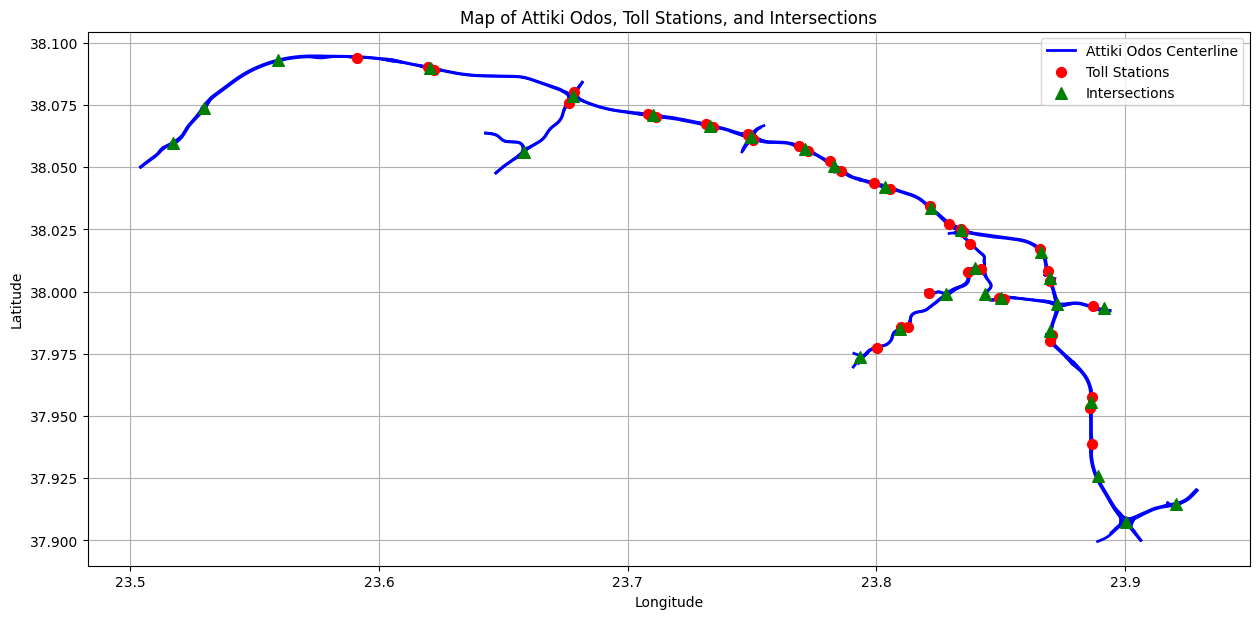

In [ ]:
import json
import matplotlib.pyplot as plt

# --- Create Plot ---
fig, ax = plt.subplots(figsize=(15, 15))

# --- Plot Attiki Odos Centerlines ---
if centerlines and 'features' in centerlines:
    for feature in centerlines['features']: #
        if feature['geometry']['type'] == 'LineString': #
            coords = feature['geometry']['coordinates'] #
            # Separate lng and lat for plotting
            lngs = [point[0] for point in coords]
            lats = [point[1] for point in coords]
            ax.plot(lngs, lats, color='blue', linewidth=2, label='Attiki Odos Centerline' if 'Attiki Odos Centerline' not in plt.gca().get_legend_handles_labels()[1] else "")

# --- Plot Toll Stations ---
if tolls:
    toll_lngs = [station['lng'] for station in tolls if 'lng' in station and 'lat' in station] #
    toll_lats = [station['lat'] for station in tolls if 'lng' in station and 'lat' in station] #
    ax.scatter(toll_lngs, toll_lats, color='red', marker='o', s=50, label='Toll Stations', zorder=5)

# --- Plot Intersections (Komvoi) ---
if komvoi:
    komvoi_lngs = [details['lng'] for komvos, details in komvoi.items() if 'lng' in details and 'lat' in details] #
    komvoi_lats = [details['lat'] for komvos, details in komvoi.items() if 'lng' in details and 'lat' in details] #
    ax.scatter(komvoi_lngs, komvoi_lats, color='green', marker='^', s=70, label='Intersections', zorder=5)

# --- Customize Plot ---
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Map of Attiki Odos, Toll Stations, and Intersections")
ax.legend()
ax.grid(True)
ax.set_aspect('equal', adjustable='box') # To make the map scale look more natural

# --- Show Plot ---
plt.show()

## calculation of euclidian and actual distance

In [ ]:
import json
import folium
import pandas as pd
from shapely.geometry import Point, LineString, MultiLineString
from shapely.ops import nearest_points, snap as shapely_snap_op # For snapping POIs precisely onto lines
import math
import networkx as nx
import itertools

accidents_df=df.copy()

# --- 0. Helper Functions ---
def haversine(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

def calculate_shapely_linestring_km_length(shapely_line):
    """Calculates geographic length of a Shapely LineString (coords are lon, lat) in km."""
    length = 0
    coords = list(shapely_line.coords)
    for i in range(len(coords) - 1):
        p1_lng, p1_lat = coords[i]
        p2_lng, p2_lat = coords[i+1]
        length += haversine(p1_lat, p1_lng, p2_lat, p2_lng)
    return length

# Snap accident to the overall road multilinestring to find which specific LineString it's on
# And the exact snapped point.
def snap_to_road_network(point_geom, road_network_multilinestring, individual_road_lines_with_ids):
    """
    Snaps a point to the road network (MultiLineString).
    Returns the snapped Point, the specific LineString it snapped to, and that LineString's ID.
    """
    if road_network_multilinestring.is_empty:
        return None, None, None

    # Find the closest point on the entire road network (MultiLineString)
    # nearest_points returns (point_on_multilinestring, original_point_geom)
    snapped_point_on_network, _ = nearest_points(road_network_multilinestring, point_geom)

    # Now, find which individual LineString this snapped_point_on_network is actually on or closest to.
    # This is because nearest_points on MultiLineString doesn't directly tell us *which* LineString.
    min_dist_to_segment = float('inf')
    best_line_geom = None
    best_line_id = None
    final_snapped_point_on_segment = snapped_point_on_network # Initial best guess

    for line_geom, line_id in individual_road_lines_with_ids:
        # Snap the already network-snapped point to this specific line to ensure it's *on* it
        # This also helps if the point was at an intersection of multiple lines in the MultiLineString
        p_on_this_line, _ = nearest_points(line_geom, snapped_point_on_network)
        dist = p_on_this_line.distance(snapped_point_on_network) # Should be very small if on/near this line

        if dist < min_dist_to_segment:
            min_dist_to_segment = dist
            best_line_geom = line_geom
            best_line_id = line_id
            final_snapped_point_on_segment = p_on_this_line
            if dist < 1e-9: # Effectively on the line, break early for this common case
                break

    return final_snapped_point_on_segment, best_line_geom, best_line_id




# --- Identify Unnamed Tolls ---
print("\n--- Checking for Unnamed Toll Stations ---")
if tolls:
    unnamed_tolls_found = False
    for i, station in enumerate(tolls):
        station_name = station.get('name', '').strip()
        if not station_name:
            unnamed_tolls_found = True
            print(f"Unnamed toll: Index {i}, Lat: {station.get('lat')}, Lng: {station.get('lng')}")
    if not unnamed_tolls_found: print("All toll stations appear to have names.")
else: print("Toll data not loaded.")
print("-------------------------------------\n")


# --- 3. Build Detailed Road Network Graph with NetworkX ---
G = nx.Graph()
node_id_counter = 0
point_to_node_id = {} # Using tuples (lng, lat) as keys
road_segment_lines_for_snapping = [] # List of (Shapely.LineString, original_feature_id)

print("Building detailed road network graph...")
if centerlines and 'features' in centerlines:
    for feature_idx, feature in enumerate(centerlines['features']):
        if feature['geometry']['type'] == 'LineString':
            coords = feature['geometry']['coordinates']
            if len(coords) < 2:
                continue

            current_road_line_shapely = LineString(coords)
            road_segment_lines_for_snapping.append((current_road_line_shapely, f"feature_{feature_idx}"))

            for i in range(len(coords)):
                p_coords = tuple(coords[i]) # (lng, lat)
                if p_coords not in point_to_node_id:
                    point_to_node_id[p_coords] = node_id_counter
                    G.add_node(node_id_counter, pos=p_coords, type='road_vertex') # pos is (lng, lat)
                    node_id_counter += 1

            for i in range(len(coords) - 1):
                p1_coords = tuple(coords[i])
                p2_coords = tuple(coords[i+1])
                node1_id = point_to_node_id[p1_coords]
                node2_id = point_to_node_id[p2_coords]
                segment_length = haversine(p1_coords[1], p1_coords[0], p2_coords[1], p2_coords[0])

                if node1_id != node2_id: # Avoid self-loops on zero-length segments if any
                    if G.has_edge(node1_id, node2_id):
                        # Update if this path is shorter (shouldn't happen with this granular build)
                        if G[node1_id][node2_id]['length'] > segment_length:
                             G.add_edge(node1_id, node2_id, length=segment_length)
                    else:
                        G.add_edge(node1_id, node2_id, length=segment_length)

# Create a MultiLineString of all road segments for efficient global snapping of POIs/accidents
all_road_linestrings = [line_geom for line_geom, _ in road_segment_lines_for_snapping]
road_network_mls = MultiLineString(all_road_linestrings) if all_road_linestrings else MultiLineString()


# Integrate POIs (Tolls and Intersections) into the graph by snapping them and splitting edges
poi_nodes_in_graph = {} # To store 'poi_unique_id' -> graph_node_id_it_connects_to_or_is

# Process Tolls
if tolls:
    for i, station_data in enumerate(tolls):
        if station_data.get('lat') and station_data.get('lng'):
            poi_id = f"toll_{station_data.get('name', i)}"
            poi_geom = Point(station_data['lng'], station_data['lat'])

            snapped_poi_geom, on_line_geom, _ = snap_to_road_network(poi_geom, road_network_mls, road_segment_lines_for_snapping)

            if snapped_poi_geom and on_line_geom:
                # Add the POI as a new node
                G.add_node(poi_id, pos=(snapped_poi_geom.x, snapped_poi_geom.y), type='toll', name=station_data.get('name', poi_id))
                poi_nodes_in_graph[poi_id] = poi_id # It's its own node

                # Find the two graph nodes making up the segment 'on_line_geom'
                # This requires iterating through original points that made the graph nodes
                p_start_coords = tuple(on_line_geom.coords[0])
                p_end_coords = tuple(on_line_geom.coords[-1]) # This is the full LineString, not micro-segment

                # Simplified: connect POI to the nearest vertex nodes of the LineString it snapped to.
                # A more complex approach would split the exact edge.
                node1_on_line_id = None
                min_dist_p1 = float('inf')
                for coord_tuple, nodeid in point_to_node_id.items():
                    if Point(coord_tuple).within(on_line_geom.buffer(1e-9)): # Check if vertex is part of this linestring
                         dist = snapped_poi_geom.distance(Point(coord_tuple))
                         if dist < min_dist_p1:
                             min_dist_p1 = dist
                             node1_on_line_id = nodeid

                if node1_on_line_id is not None: # Connect snapped POI to this closest existing road vertex node
                    dist_to_n1 = haversine(snapped_poi_geom.y, snapped_poi_geom.x, G.nodes[node1_on_line_id]['pos'][1], G.nodes[node1_on_line_id]['pos'][0])
                    G.add_edge(poi_id, node1_on_line_id, length=dist_to_n1)


# Process Intersections (Komvoi) - similar logic to tolls
if komvoi:
    for komvos_id_str, details in komvoi.items():
        if details.get('lat') and details.get('lng'):
            poi_id = f"intersection_{komvos_id_str}"
            poi_geom = Point(details['lng'], details['lat'])

            snapped_poi_geom, on_line_geom, _ = snap_to_road_network(poi_geom, road_network_mls, road_segment_lines_for_snapping)

            if snapped_poi_geom and on_line_geom:
                G.add_node(poi_id, pos=(snapped_poi_geom.x, snapped_poi_geom.y), type='intersection', name=f"Intersection: {komvos_id_str}")
                poi_nodes_in_graph[poi_id] = poi_id

                node1_on_line_id = None
                min_dist_p1 = float('inf')
                for coord_tuple, nodeid in point_to_node_id.items():
                    if Point(coord_tuple).within(on_line_geom.buffer(1e-9)):
                         dist = snapped_poi_geom.distance(Point(coord_tuple))
                         if dist < min_dist_p1:
                             min_dist_p1 = dist
                             node1_on_line_id = nodeid

                if node1_on_line_id is not None:
                    dist_to_n1 = haversine(snapped_poi_geom.y, snapped_poi_geom.x, G.nodes[node1_on_line_id]['pos'][1], G.nodes[node1_on_line_id]['pos'][0])
                    G.add_edge(poi_id, node1_on_line_id, length=dist_to_n1)


print(f"Graph refined with POIs: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


# --- 4. Calculate Distances for Accidents (using refined NetworkX graph) ---
results = []
if not accidents_df.empty and road_segment_lines_for_snapping:
    print("Processing accidents for distances (Euclidean and improved NetworkX)...")
    for index, acc_row in accidents_df.iterrows():
        acc_lat, acc_lng = acc_row['lat'], acc_row['lng']
        acc_type = acc_row['accident_type']
        acc_id = acc_row.get('id', index)
        accident_shapely_geom = Point(acc_lng, acc_lat)

        # Snap accident to the road network to get precise point and segment
        snapped_acc_point_geom, on_road_line_geom, _ = \
            snap_to_road_network(accident_shapely_geom, road_network_mls, road_segment_lines_for_snapping)

        acc_result = { # Initialize with defaults
            'acc_id': acc_id, 'acc_type': acc_type,
            'original_lat': acc_lat, 'original_lng': acc_lng,
            'snapped_lat': snapped_acc_point_geom.y if snapped_acc_point_geom else acc_lat,
            'snapped_lng': snapped_acc_point_geom.x if snapped_acc_point_geom else acc_lng,
            'closest_toll_euclidean_km': float('nan'), 'closest_toll_euclidean_name': 'N/A',
            'closest_intersection_euclidean_km': float('nan'), 'closest_intersection_euclidean_name': 'N/A',
            'closest_toll_network_km': float('nan'), 'closest_toll_network_name': 'N/A',
            'closest_intersection_network_km': float('nan'), 'closest_intersection_network_name': 'N/A'
        }

        if not snapped_acc_point_geom or not on_road_line_geom:
            print(f"Warning: Accident ID {acc_id} could not be snapped. Skipping network calculations.")
            results.append(acc_result)
            continue

        current_snapped_lat, current_snapped_lng = snapped_acc_point_geom.y, snapped_acc_point_geom.x

        # Euclidean distances
        # (Using the full POI list with original coords for Euclidean, snapping POIs for network)
        temp_tolls = [p for p_id, p in G.nodes(data=True) if p.get('type') == 'toll']
        temp_intersections = [p for p_id, p in G.nodes(data=True) if p.get('type') == 'intersection']

        if temp_tolls:
            closest_toll_euc = min(temp_tolls, key=lambda p: haversine(current_snapped_lat, current_snapped_lng, p['pos'][1], p['pos'][0]))
            acc_result['closest_toll_euclidean_km'] = haversine(current_snapped_lat, current_snapped_lng, closest_toll_euc['pos'][1], closest_toll_euc['pos'][0])
            acc_result['closest_toll_euclidean_name'] = closest_toll_euc['name']

        if temp_intersections:
            closest_int_euc = min(temp_intersections, key=lambda p: haversine(current_snapped_lat, current_snapped_lng, p['pos'][1], p['pos'][0]))
            acc_result['closest_intersection_euclidean_km'] = haversine(current_snapped_lat, current_snapped_lng, closest_int_euc['pos'][1], closest_int_euc['pos'][0])
            acc_result['closest_intersection_euclidean_name'] = closest_int_euc['name']

        # Network distances
        # Find the two nodes of the segment the accident snapped to
        segment_node1_coords = tuple(on_road_line_geom.coords[0])
        segment_node2_coords = tuple(on_road_line_geom.coords[-1]) # Using the full LineString from aocenterlines here

        # Find the graph nodes closest to the segment endpoints on which the accident lies
        # This assumes snapped_acc_point_geom is on a micro-segment whose vertices are graph nodes.
        node1_id = None
        node2_id = None
        min_d1 = float('inf')
        min_d2 = float('inf')

        # This part needs to map segment endpoints of `on_road_line_geom` to actual graph node IDs
        # A better way: `snap_to_road_network` should return the *micro-segment* endpoints if possible
        # For now, find closest graph nodes to the snapped accident point

        # Simplified connection: Find closest graph node to the snapped accident point
        # This single node will be the source for shortest path.
        # This is an approximation for the "access link".
        source_node_for_accident = None
        min_dist_to_graph_node = float('inf')

        for node_id, data in G.nodes(data=True):
            if 'pos' in data: # Ensure node has position
                dist = haversine(current_snapped_lat, current_snapped_lng, data['pos'][1], data['pos'][0])
                if dist < min_dist_to_graph_node:
                    min_dist_to_graph_node = dist
                    source_node_for_accident = node_id

        if source_node_for_accident is not None:
            acc_result['dist_to_entry_node_km'] = min_dist_to_graph_node

            # Closest Toll via Network
            min_net_dist_toll = float('inf')
            for target_node_id, data in G.nodes(data=True):
                if data.get('type') == 'toll':
                    try:
                        if nx.has_path(G, source=source_node_for_accident, target=target_node_id):
                            path_len = nx.shortest_path_length(G, source=source_node_for_accident, target=target_node_id, weight='length')
                            total_dist = min_dist_to_graph_node + path_len
                            if total_dist < min_net_dist_toll:
                                min_net_dist_toll = total_dist
                                acc_result['closest_toll_network_km'] = total_dist
                                acc_result['closest_toll_network_name'] = data['name']
                    except nx.NetworkXNoPath:
                        pass

            # Closest Intersection via Network
            min_net_dist_int = float('inf')
            for target_node_id, data in G.nodes(data=True):
                if data.get('type') == 'intersection':
                    try:
                        if nx.has_path(G, source=source_node_for_accident, target=target_node_id):
                            path_len = nx.shortest_path_length(G, source=source_node_for_accident, target=target_node_id, weight='length')
                            total_dist = min_dist_to_graph_node + path_len
                            if total_dist < min_net_dist_int:
                                min_net_dist_int = total_dist
                                acc_result['closest_intersection_network_km'] = total_dist
                                acc_result['closest_intersection_network_name'] = data['name']
                    except nx.NetworkXNoPath:
                        pass
        else:
            print(f"Accident ID {acc_id}: Could not connect snapped point to any graph node.")

        results.append(acc_result)
        # More detailed print per accident can be re-added if needed

    results_df = pd.DataFrame(results)
    print("\n--- Calculated Distances DataFrame (NetworkX - More Detailed Graph Attempt) ---")
    print(results_df)
else:
    print("Accident data or road data is missing/empty. Cannot perform calculations.")
    results_df = pd.DataFrame()

# --- 5. Create/Update Folium Map ---
# (Folium map plotting code remains largely the same as previous, just uses the new results_df columns)
map_center_lat = 38.03
map_center_lng = 23.80
attiki_map_final = folium.Map(location=[map_center_lat, map_center_lng], zoom_start=10)

centerlines_group = folium.FeatureGroup(name="Attiki Odos Centerlines", show=True).add_to(attiki_map_final)
tolls_map_group = folium.FeatureGroup(name="Toll Stations", show=True).add_to(attiki_map_final)
intersections_map_group = folium.FeatureGroup(name="Intersections", show=True).add_to(attiki_map_final)
accidents_map_group = folium.FeatureGroup(name="Accidents (with Info)", show=True).add_to(attiki_map_final)
# graph_nodes_group = folium.FeatureGroup(name="Road Network Nodes", show=False).add_to(attiki_map_final)


if centerlines and 'features' in centerlines:
    for feature in centerlines['features']:
        if feature['geometry']['type'] == 'LineString':
            coords = feature['geometry']['coordinates']
            folium_coords = [(point[1], point[0]) for point in coords]
            folium.PolyLine(folium_coords, color='blue', weight=2.5, opacity=0.6).add_to(centerlines_group)

# Plot POIs (which are also graph nodes now)
for node_id, data in G.nodes(data=True):
    if data.get('type') == 'toll':
        folium.CircleMarker(
            location=(data['pos'][1], data['pos'][0]), radius=6, color='darkred',
            fill=True, fill_color='red', fill_opacity=0.7, tooltip=data.get('name', node_id)
        ).add_to(tolls_map_group)
    elif data.get('type') == 'intersection':
        folium.Marker(
            location=(data['pos'][1], data['pos'][0]),
            tooltip=data.get('name', node_id),
            icon=folium.Icon(color='green', icon='transfer', prefix='glyphicon')
        ).add_to(intersections_map_group)
    # Optional: visualize all road_vertex nodes
    # elif data.get('type') == 'road_vertex':
    #     folium.CircleMarker(location=(data['pos'][1], data['pos'][0]), radius=1, color='gray').add_to(graph_nodes_group)


if not results_df.empty:
    for index, row in results_df.iterrows():
        popup_html = (f"<b>Acc ID:</b> {row['acc_id']} ({row['acc_type']})<br>"
                      f"<b>Snapped:</b> ({row['snapped_lat']:.5f}, {row['snapped_lng']:.5f})<br><hr>"
                      f"<b><u>Euclidean:</u></b><br>"
                      f"<b>Toll:</b> {row['closest_toll_euclidean_name']} ({row.get('closest_toll_euclidean_km', float('nan')):.2f} km)<br>"
                      f"<b>Int:</b> {row['closest_intersection_euclidean_name']} ({row.get('closest_intersection_euclidean_km', float('nan')):.2f} km)<br><hr>"
                      f"<b><u>Network Path (Approx):</u></b><br>"
                      f"<b>Toll:</b> {row['closest_toll_network_name']} ({row.get('closest_toll_network_km', float('nan')):.2f} km)<br>"
                      f"<b>Int:</b> {row['closest_intersection_network_name']} ({row.get('closest_intersection_network_km', float('nan')):.2f} km)<br>"
                      f"<i>(Access to graph: {row.get('dist_to_entry_node_km', float('nan')):.2f} km)</i>")

        icon_color = 'orange' if row['acc_type'] == 'injury' else 'black'
        icon_glyph = 'exclamation-sign' if row['acc_type'] == 'injury' else 'plus'

        folium.Marker(
            location=[row['snapped_lat'], row['snapped_lng']],
            popup=folium.Popup(popup_html, max_width=450),
            tooltip=f"Accident {row['acc_id']} ({row['acc_type']})",
            icon=folium.Icon(color=icon_color, icon=icon_glyph, prefix='glyphicon')
        ).add_to(accidents_map_group)

folium.LayerControl().add_to(attiki_map_final)

# --- Display Map ---
attiki_map_final


--- Checking for Unnamed Toll Stations ---
All toll stations appear to have names.
-------------------------------------

Building detailed road network graph...
Graph refined with POIs: 6471 nodes and 6357 edges.
Processing accidents for distances (Euclidean and improved NetworkX)...

--- Calculated Distances DataFrame (NetworkX - More Detailed Graph Attempt) ---
     acc_id acc_type  original_lat  original_lng  snapped_lat  snapped_lng  \
0         0   injury     37.975077     23.795987    37.975077    23.795988   
1         1   injury     38.008220     23.842947    38.008221    23.842947   
2         2   injury     38.057868     23.513206    38.057868    23.513206   
3         3   injury     37.997137     23.825595    37.997137    23.825595   
4         4   injury     38.062757     23.746719    38.062757    23.746719   
..      ...      ...           ...           ...          ...          ...   
518     522    death     38.043442     23.799442    38.043441    23.799442   
519     

In [ ]:
# Print all the different values that appear in the column ΣΤΑΘΜ.ΔΙΟΔΙΩΝ
print(df['ΣΤΑΘΜ.ΔΙΟΔΙΩΝ'].unique())

[nan 'ΚΑΤΕΧΑΚΗ ΒΟΡΕΙΑ' 'ΔΗΜΟΚΡΑΤΙΑΣ ΑΝΑΤΟΛΙΚΑ' 'ΦΥΛΗΣ ΑΝΑΤΟΛΙΚΑ'
 'ΚΟΡΩΠΙ ΔΥΤΙΚΑ' 'ΗΡΑΚΛΕΙΟ ΑΝΑΤΟΛΙΚΗ' 'ΚΗΦΙΣΙΑΣ ΑΝΑΤΟΛΙΚΗ' 'ΠΑΛΛΗΝΗ ΝΟΤΙΑ'
 'ΡΟΥΠΑΚΙ ΑΝΑΤΟΛΙΚΑ' 'ΜΕΤΑΜΟΡΦΩΣΗ ΑΝΑΤΟΛΙΚΗ / Λ.' 'ΑΣΠΡΟΠΥΡΓΟΣ ΑΝΑΤΟΛΙΚΑ'
 'ΚΥΜΗΣ ΔΥΤΙΚΑ' 'ΠΑΙΑΝΙΑ ΔΥΤΙΚΗ']


## using the current entries for POIs in order to calculate the distances

In [ ]:
import json
import folium
import pandas as pd
from shapely.geometry import Point, LineString, MultiLineString
from shapely.ops import nearest_points
import math
import networkx as nx
import itertools # For iterating over pairs of points in a linestring
import unicodedata # Import unicodedata
import re


# --- 0. Helper Functions ---
def haversine(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

def calculate_shapely_linestring_km_length(shapely_line):
    length = 0
    coords = list(shapely_line.coords)
    for i in range(len(coords) - 1):
        p1_lng, p1_lat = coords[i]
        p2_lng, p2_lat = coords[i+1]
        length += haversine(p1_lat, p1_lng, p2_lat, p2_lng)
    return length

def snap_to_road_network(point_geom, road_network_multilinestring, individual_road_lines_with_ids):
    if not road_network_multilinestring or road_network_multilinestring.is_empty:
        return None, None, None
    snapped_point_on_network, _ = nearest_points(road_network_multilinestring, point_geom)
    min_dist_to_segment = float('inf')
    best_line_geom = None
    best_line_id = None
    final_snapped_point_on_segment = snapped_point_on_network
    for line_geom, line_id in individual_road_lines_with_ids:
        p_on_this_line, _ = nearest_points(line_geom, snapped_point_on_network)
        dist = p_on_this_line.distance(snapped_point_on_network)
        if dist < min_dist_to_segment:
            min_dist_to_segment = dist
            best_line_geom = line_geom
            best_line_id = line_id
            final_snapped_point_on_segment = p_on_this_line
            if dist < 1e-9: break
    return final_snapped_point_on_segment, best_line_geom, best_line_id

# --- REFINED: Helper function for name normalization ---
# def normalize_poi_name(name):
#     if not isinstance(name, str):
#         return None

#     name_upper = name.upper().strip()

#     # Step 1: General Greek directionals to common abbreviations (longer versions first)
#     # Ensure consistency, e.g., always end with a dot or always without. Let's aim for NO dot.
#     replacements = {
#         "ΒΟΡΕΙΑ": "ΒΟΡ", "ΑΝΑΤΟΛΙΚΑ": "ΑΝ", "ΔΥΤΙΚΑ": "ΔΥΤ", "ΝΟΤΙΑ": "ΝΟΤ",
#         "ΒΟΡΕΙΟΣ": "ΒΟΡ", "ΑΝΑΤΟΛΙΚΟΣ": "ΑΝ", "ΔΥΤΙΚΟΣ": "ΔΥΤ", "ΝΟΤΙΟΣ": "ΝΟΤ",
#         "ΒΟΡ.": "ΒΟΡ", "ΑΝ.": "ΑΝ", "ΔΥΤ.": "ΔΥΤ", "ΝΟΤ.": "ΝΟΤ", # With dot to no dot
#         # English equivalents to Greek abbreviations
#         "NORTH": "ΒΟΡ", "EAST": "ΑΝ", "WEST": "ΔΥΤ", "SOUTH": "ΝΟΤ"
#     }
#     for old, new in replacements.items():
#         name_upper = name_upper.replace(old, new)

#     # Step 2: Remove common prefixes and suffixes, careful with order
#     name_upper = name_upper.replace("ΔΙΟΔΙΑ ", "").replace("ΔΙΟΔΙΩΝ ", "")
#     name_upper = name_upper.replace("ΣΤΑΘΜΟΣ ", "").replace("ΣΤ ", "")

#     # Step 3: Handle specific complex cases and known discrepancies (expand this list based on your data)
#     # Standardize variations of 'ΜΕΤΑΜΟΡΦΩΣΗ' to one canonical form
#     if "ΜΕΤΑΜΟΡΦΩΣΗ" in name_upper and ("ΑΝ" in name_upper or "ΑΝΑΤΟΛΙΚΗ" in name_upper):
#         name_upper = "ΜΕΤΑΜΟΡΦΩΣΗΣ ΑΝ" # Target for JSON: "ΜΕΤΑΜΟΡΦΩΣΗΣ ΑΝ."
#     if "DIODIA METAMORFOSIS DUTIKA APO PEIRAIA" in name_upper:
#         name_upper = "ΜΕΤΑΜΟΡΦΩΣΗ ΔΥΤ"

#     # Step 4: Standardize common abbreviations like Αγία/Άγιος
#     name_upper = name_upper.replace("ΑΓΙΑ ", "ΑΓ ").replace("ΑΓΙΟΣ ", "ΑΓ ").replace("ΑΓΙΟΥ ", "ΑΓ ")
#     name_upper = name_upper.replace("ΑΓ.", "ΑΓ")

#     # Step 5: Remove all remaining punctuation (dots, slashes, etc.) and consolidate whitespace
#     name_upper = re.sub(r'[^\w\s]', '', name_upper) # Remove punctuation except whitespace
#     name_upper = re.sub(r'\s+', ' ', name_upper).strip() # Consolidate multiple spaces and strip

#     # Step 6: Specific hardcoded mappings for stubborn cases AFTER general normalization
#     # Keys here should be the result of the above normalization steps on CSV names
#     # Values should be the result of the above normalization steps on JSON names (i.e., the keys in toll_coord_lookup)
#     specific_mappings = {
#         "ΚΑΤΕΧΑΚΗ ΒΟΡ": "ΚΑΤΕΧΑΚΗ ΒΟΡ", # Should already match if JSON is 'KATEXAKH BΟΡ.'
#         "ΗΡΑΚΛΕΙΟ ΑΝ": "ΗΡΑΚΛΕΙΟΥ ΑΝ",    # CSV 'ΗΡΑΚΛΕΙΟ ΑΝΑΤΟΛΙΚΗ' -> 'ΗΡΑΚΛΕΙΟ ΑΝ' maps to JSON 'ΗΡΑΚΛΕΙΟΥ ΑΝ.' -> 'ΗΡΑΚΛΕΙΟΥ ΑΝ'
#         "ΚΗΦΙΣΙΑΣ ΑΝ": "ΚΗΦΙΣΙΑΣ ΑΝ",    # CSV 'ΚΗΦΙΣΙΑΣ ΑΝΑΤΟΛΙΚΗ' -> 'ΚΗΦΙΣΙΑΣ ΑΝ' should match JSON 'ΚΗΦΙΣΙΑΣ ΑΝ.' -> 'ΚΗΦΙΣΙΑΣ ΑΝ'
#         "ΚΟΡΩΠΙ ΔΥΤ": "ΚΟΡΩΠΙΟΥ ΔΥΤ",    # CSV 'ΚΟΡΩΠΙ ΔΥΤΙΚΑ' -> 'ΚΟΡΩΠΙ ΔΥΤ' maps to JSON 'ΚΟΡΩΠΙΟΥ ΔΥΤ.' -> 'ΚΟΡΩΠΙΟΥ ΔΥΤ'
#         "ΑΣΠΡΟΠΥΡΓΟΣ ΑΝ": "ΑΣΠΡΟΠΥΡΓΟΥ ΑΝ",# CSV 'ΑΣΠΡΟΠΥΡΓΟΣ ΑΝΑΤΟΛΙΚΑ' -> 'ΑΣΠΡΟΠΥΡΓΟΣ ΑΝ' maps to JSON 'ΑΣΠΡΟΠΥΡΓΟΥ ΑΝ.' -> 'ΑΣΠΡΟΠΥΡΓΟΥ ΑΝ'
#         "ΠΑΙΑΝΙΑ ΔΥΤΙΚΗ": "ΠΑΙΑΝΙΑΣ ΔΥΤ",  # CSV 'ΠΑΙΑΝΙΑ ΔΥΤΙΚΗ' -> 'ΠΑΙΑΝΙΑ ΔΥΤΙΚΗ' maps to JSON 'ΠΑΙΑΝΙΑΣ ΔΥΤ.' -> 'ΠΑΙΑΝΙΑΣ ΔΥΤ'
#         "ΠΑΛΛΗΝΗ ΝΟΤ": "ΠΑΛΛΗΝΗΣ ΝΟΤ",    # CSV 'ΠΑΛΛΗΝΗ ΝΟΤΙΑ' -> 'ΠΑΛΛΗΝΗ ΝΟΤ' maps to JSON 'ΠΑΛΛΗΝΗΣ ΝΟΤ.' -> 'ΠΑΛΛΗΝΗΣ ΝΟΤ'
#         "ΡΟΥΠΑΚΙ ΑΝ" : "ΡΟΥΠΑΚΙΟΥ ΑΝ"     # CSV 'ΡΟΥΠΑΚΙ ΑΝΑΤΟΛΙΚΑ' -> 'ΡΟΥΠΑΚΙ ΑΝ' maps to JSON 'ΡΟΥΠΑΚΙΟΥ ΑΝ.' -> 'ΡΟΥΠΑΚΙΟΥ ΑΝ'
#         # Add any other specific final adjustments here based on your diagnostic output.
#         # The key is the *normalized CSV name*, the value is the *normalized JSON name*
#     }
#     if name_upper in specific_mappings:
#         return specific_mappings[name_upper]

#     return name_upper
def normalize_poi_name(name):
    if not isinstance(name, str):
        return None

    name_normalized_unicode = unicodedata.normalize('NFKC', name)
    name_upper = name_normalized_unicode.upper().strip()

    # Order of specific mappings is important. More specific should come first.
    # Handle complex cases first
    if "ΜΕΤΑΜΟΡΦΩΣΗ" in name_upper and ("ΑΝ" in name_upper or "ΑΝΑΤΟΛΙΚΗ" in name_upper) and "/" in name_upper:
        name_upper = "ΜΕΤΑΜΟΡΦΩΣΗΣ ΑΝ"
    elif "DIODIA METAMORFOSIS DUTIKA APO PEIRAIA" in name_upper:
        name_upper = "ΜΕΤΑΜΟΡΦΩΣΗ ΔΥΤ"
    # elif "ΜΕΤΑΜΟΡΦΩΣΗΣ ΑΝ." in name_upper: # JSON side normalization for this specific case
    #     name_upper = "ΜΕΤΑΜΟΡΦΩΣΗΣ ΑΝ"
    # elif "ΜΕΤΑΜΟΡΦΩΣΗ ΔΥΤ." in name_upper: # JSON side normalization for this specific case
    #     name_upper = "ΜΕΤΑΜΟΡΦΩΣΗ ΔΥΤ"


    # General Greek directionals to common abbreviations
    replacements = {
        "ΒΟΡΕΙΑ": "ΒΟΡ", "ΑΝΑΤΟΛΙΚΑ": "ΑΝ", "ΔΥΤΙΚΑ": "ΔΥΤ", "ΝΟΤΙΑ": "ΝΟΤ", # Long forms
        "ΒΟΡΕΙΟΣ": "ΒΟΡ", "ΑΝΑΤΟΛΙΚΟΣ": "ΑΝ", "ΔΥΤΙΚΟΣ": "ΔΥΤ", "ΝΟΤΙΟΣ": "ΝΟΤ",
        "ΒΟΡ.": "ΒΟΡ", "ΑΝ.": "ΑΝ", "ΔΥΤ.": "ΔΥΤ", "ΝΟΤ.": "ΝΟΤ",         # Abbreviated forms with dot
        "NORTH": "ΒΟΡ", "EAST": "ΑΝ", "WEST": "ΔΥΤ", "SOUTH": "ΝΟΤ"          # English
    }
    # Apply replacements for full words first to avoid partial replacements
    # Sort replacements by length of key, descending, to replace longer substrings first
    sorted_replacements = dict(sorted(replacements.items(), key=lambda item: len(item[0]), reverse=True))

    for old, new in sorted_replacements.items():
        name_upper = name_upper.replace(old, new)

    name_upper = name_upper.replace("ΔΙΟΔΙΑ ", "").replace("ΔΙΟΔΙΩΝ ", "")
    name_upper = name_upper.replace("ΣΤΑΘΜΟΣ ", "").replace("ΣΤ ", "")
    name_upper = name_upper.replace("ΑΓΙΑ ", "ΑΓ ").replace("ΑΓΙΟΣ ", "ΑΓ ").replace("ΑΓΙΟΥ ", "ΑΓ ")
    name_upper = name_upper.replace("ΑΓ.", "ΑΓ")

    # Remove all remaining punctuation (dots, slashes, etc.) and consolidate whitespace
    name_upper = re.sub(r'[^\w\sΑ-ΩΆΈΉΊΌΎΏΪΫ]', '', name_upper, flags=re.UNICODE)
    name_upper = re.sub(r'\s+', ' ', name_upper).strip()

    # Final specific mappings based on observed diagnostic output
    # Keys are what the CSV name NORMALIZES TO *before this step*
    # Values are what the JSON name NORMALIZES TO (i.e., the desired key in toll_coord_lookup)
    specific_mappings = {
        # From your logs:
        "ΗΡΑΚΛΕΙΟ ΑΝΑΤΟΛΙΚΗ": "ΗΡΑΚΛΕΙΟΥ ΑΝ", # CSV 'ΗΡΑΚΛΕΙΟ ΑΝΑΤΟΛΙΚΗ' (if it bypasses earlier AN repl) -> JSON 'ΗΡΑΚΛΕΙΟΥ ΑΝ'
        "ΚΗΦΙΣΙΑΣ ΑΝΑΤΟΛΙΚΗ": "ΚΗΦΙΣΙΑΣ ΑΝ", # CSV 'ΚΗΦΙΣΙΑΣ ΑΝΑΤΟΛΙΚΗ' (if it bypasses earlier AN repl) -> JSON 'ΚΗΦΙΣΙΑΣ ΑΝ'
        "ΚΑΤΕΧΑΚΗ ΒΟΡΕΙΑ": "ΚΑΤΕΧΑΚΗ ΒΟΡ",   # If 'ΚΑΤΕΧΑΚΗ ΒΟΡ' is the key from JSON

        # Add previous successful mappings to ensure they remain correct
        "ΚΟΡΩΠΙ ΔΥΤ": "ΚΟΡΩΠΙΟΥ ΔΥΤ",
        "ΑΣΠΡΟΠΥΡΓΟΣ ΑΝ": "ΑΣΠΡΟΠΥΡΓΟΥ ΑΝ",
        "ΠΑΙΑΝΙΑ ΔΥΤΙΚΗ": "ΠΑΙΑΝΙΑΣ ΔΥΤ",
        "ΠΑΛΛΗΝΗ ΝΟΤ": "ΠΑΛΛΗΝΗΣ ΝΟΤ",
        "ΡΟΥΠΑΚΙ ΑΝ" : "ΡΟΥΠΑΚΙΟΥ ΑΝ",
        "ΜΕΤΑΜΟΡΦΩΣΗ ΑΝ Λ": "ΜΕΤΑΜΟΡΦΩΣΗΣ ΑΝ", # This was a prior specific case
        "DIODIA METAMORFOSIS DUTIKA APO PEIRAIA": "ΜΕΤΑΜΟΡΦΩΣΗ ΔΥΤ"
    }

    # Try the specific mapping directly on the "almost normalized" name_upper
    if name_upper in specific_mappings:
        return specific_mappings[name_upper]

    # If specific mapping didn't catch it, try one more pass of directional replacement
    # on the current name_upper in case previous steps didn't fully reduce it.
    # This is to catch cases where "ΑΝΑΤΟΛΙΚΗ" might still exist.
    name_after_specific_map_attempt = name_upper # Store current state
    for old, new in sorted_replacements.items():
        name_after_specific_map_attempt = name_after_specific_map_attempt.replace(old, new)

    name_after_specific_map_attempt = re.sub(r'[^\w\sΑ-ΩΆΈΉΊΌΎΏΪΫ]', '', name_after_specific_map_attempt, flags=re.UNICODE)
    name_after_specific_map_attempt = re.sub(r'\s+', ' ', name_after_specific_map_attempt).strip()

    if name_after_specific_map_attempt in specific_mappings:
        return specific_mappings[name_after_specific_map_attempt]

    # Fallback to the generally normalized name if no specific mapping applied to the result of this second pass
    return name_after_specific_map_attempt


# --- Start of script (assuming df, centerlines, tolls, komvoi are loaded) ---
# Make sure to replace placeholder df with your actual DataFrame
# accidents_df = df.copy() # If df is your main DataFrame

# --- Create POI Coordinate Lookups ---
komvoi_coord_lookup = {}
if komvoi: # Use the variable name from your provided snippet
    for k_id_str, details in komvoi.items():
        if isinstance(details, dict) and details.get('lat') and details.get('lng'):
            # Key by string ID, and also by integer part if ID is like "Y1", "K1" vs "1", "2"
            komvoi_coord_lookup[k_id_str.upper()] = (details['lat'], details['lng'])
            try:
                # Attempt to store purely numeric IDs as strings of integers
                komvoi_coord_lookup[str(int(float(k_id_str)))] = (details['lat'], details['lng'])
            except ValueError:
                pass # k_id_str was not purely numeric (e.g., "Y1"), already stored by its string key

toll_coord_lookup = {}
if tolls: # Use the variable name from your provided snippet
    print("\n--- Toll Station Names from JSON (for mapping check) ---")
    for station in tolls:
        if isinstance(station, dict) and station.get('lat') and station.get('lng'):
            original_name = station.get('name', '').strip()
            # Normalize names from the JSON file as well for a consistent lookup key
            normalized_name_json = normalize_poi_name(original_name)
            if normalized_name_json: # Only add if name exists and is not empty after normalization
                print(f"Mapping JSON Toll: '{original_name}' -> Normalized Key: '{normalized_name_json}'")
                toll_coord_lookup[normalized_name_json] = (station['lat'], station['lng'])
    print("-----------------------------------------------------------\n")


# --- The rest of your script (graph building, main loop) continues from here ---
# Ensure `centerlines` is used for graph building, not just `centerlines` if that's just a placeholder.
# The script snippet you provided uses `centerlines`, `tolls`, `komvoi` in the POI list prep
# and graph building. I'll assume these are correctly referencing your loaded JSON data.

# --- Identify Unnamed Tolls (using tolls) ---
print("\n--- Checking for Unnamed Toll Stations (from tolls) ---")
if tolls:
    unnamed_tolls_found = False
    for i, station in enumerate(tolls):
        if isinstance(station, dict):
            station_name = station.get('name', '').strip()
            if not station_name:
                unnamed_tolls_found = True
                print(f"Unnamed toll in tolls: Index {i}, Lat: {station.get('lat')}, Lng: {station.get('lng')}")
    if not unnamed_tolls_found:
        print("All toll stations in tolls appear to have names.")
else:
    print("tolls not loaded, cannot check for unnamed tolls.")
print("-------------------------------------\n")


# --- 3. Build Detailed Road Network Graph with NetworkX ---
G = nx.Graph()
node_id_counter = 0
point_to_node_id = {}
road_segment_lines_for_snapping = []

print("Building detailed road network graph...")
if centerlines and 'features' in centerlines: # Use centerlines
    for feature_idx, feature in enumerate(centerlines['features']):
        if feature['geometry']['type'] == 'LineString':
            coords = feature['geometry']['coordinates']
            if len(coords) < 2: continue

            current_road_line_shapely = LineString(coords)
            # Store with a unique ID for the original LineString feature
            road_segment_lines_for_snapping.append((current_road_line_shapely, f"feature_{feature_idx}"))

            for i in range(len(coords)):
                p_coords = tuple(coords[i])
                if p_coords not in point_to_node_id:
                    point_to_node_id[p_coords] = node_id_counter
                    G.add_node(node_id_counter, pos=p_coords, type='road_vertex')
                    node_id_counter += 1

            for i in range(len(coords) - 1):
                p1_coords = tuple(coords[i])
                p2_coords = tuple(coords[i+1])
                node1_id = point_to_node_id[p1_coords]
                node2_id = point_to_node_id[p2_coords]
                segment_length = haversine(p1_coords[1], p1_coords[0], p2_coords[1], p2_coords[0])
                if node1_id != node2_id:
                    if G.has_edge(node1_id, node2_id):
                        if G[node1_id][node2_id]['length'] > segment_length:
                             G.add_edge(node1_id, node2_id, length=segment_length)
                    else:
                        G.add_edge(node1_id, node2_id, length=segment_length)

all_road_linestrings = [line_geom for line_geom, _ in road_segment_lines_for_snapping]
road_network_mls = MultiLineString(all_road_linestrings) if all_road_linestrings else MultiLineString()

# Integrate POIs by adding them as nodes and connecting to the *nearest graph vertex*
# This is a simplification; ideally, we'd snap to an edge and split it.
if tolls: # Use tolls
    for i, station_data in enumerate(tolls):
        if isinstance(station_data, dict) and station_data.get('lat') and station_data.get('lng'):
            poi_name = station_data.get('name', f"UnnamedToll_{i}")
            poi_id = f"toll_{normalize_poi_name(poi_name)}_{i}" # Ensure unique ID
            poi_geom = Point(station_data['lng'], station_data['lat'])

            # Find closest *vertex* node in the existing graph G
            closest_graph_node_id = None
            min_dist_to_vertex = float('inf')
            for node_id, data in G.nodes(data=True):
                if data.get('type') == 'road_vertex':
                    dist = haversine(poi_geom.y, poi_geom.x, data['pos'][1], data['pos'][0])
                    if dist < min_dist_to_vertex:
                        min_dist_to_vertex = dist
                        closest_graph_node_id = node_id

            if closest_graph_node_id is not None and min_dist_to_vertex < 0.5: # Connect if within 500m of a vertex
                G.add_node(poi_id, pos=(poi_geom.x, poi_geom.y), type='toll', name=poi_name)
                G.add_edge(poi_id, closest_graph_node_id, length=min_dist_to_vertex)
            # else: POI is too far from any road vertex to be simply connected this way or no vertices in graph

if komvoi: # Use komvoi
    for komvos_id_str, details in komvoi.items():
        if isinstance(details, dict) and details.get('lat') and details.get('lng'):
            poi_name = f"Intersection: {komvos_id_str}"
            poi_id = f"intersection_{komvos_id_str}"
            poi_geom = Point(details['lng'], details['lat'])

            closest_graph_node_id = None
            min_dist_to_vertex = float('inf')
            for node_id, data in G.nodes(data=True):
                if data.get('type') == 'road_vertex': # only connect to road vertices
                    dist = haversine(poi_geom.y, poi_geom.x, data['pos'][1], data['pos'][0])
                    if dist < min_dist_to_vertex:
                        min_dist_to_vertex = dist
                        closest_graph_node_id = node_id

            if closest_graph_node_id is not None and min_dist_to_vertex < 0.5: # Connect if within 500m
                G.add_node(poi_id, pos=(poi_geom.x, poi_geom.y), type='intersection', name=poi_name)
                G.add_edge(poi_id, closest_graph_node_id, length=min_dist_to_vertex)


print(f"Graph refined with POIs: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


# --- 4. Calculate Distances for Accidents ---
results = []
# Make sure accidents_df is defined and populated from your actual data
# Example: accidents_df = df.copy() if df is your loaded accident data

if 'accidents_df' in locals() and not accidents_df.empty and road_segment_lines_for_snapping:
    print("Processing accidents for distances...")
    for index, acc_row in accidents_df.iterrows():
        acc_lat, acc_lng = acc_row['lat'], acc_row['lng']
        acc_type = acc_row['accident_type']
        acc_id = acc_row.get('id', index)
        accident_shapely_geom = Point(acc_lng, acc_lat)

        snapped_acc_point_geom, on_road_line_geom, _ = \
            snap_to_road_network(accident_shapely_geom, road_network_mls, road_segment_lines_for_snapping)

        current_snapped_lat = snapped_acc_point_geom.y if snapped_acc_point_geom else acc_lat
        current_snapped_lng = snapped_acc_point_geom.x if snapped_acc_point_geom else acc_lng

        acc_result = {
            'acc_id': acc_id, 'acc_type': acc_type,
            'original_lat': acc_lat, 'original_lng': acc_lng,
            'snapped_lat': current_snapped_lat, 'snapped_lng': current_snapped_lng,
            'closest_toll_euclidean_km': float('nan'), 'closest_toll_euclidean_name': 'N/A',
            'closest_intersection_euclidean_km': float('nan'), 'closest_intersection_euclidean_name': 'N/A',
            'recorded_toll_dist_km': float('nan'), 'recorded_toll_name': 'N/A',
            'recorded_intersection_dist_km': float('nan'), 'recorded_intersection_name': 'N/A',
            'closest_toll_network_km': float('nan'), 'closest_toll_network_name': 'N/A',
            'closest_intersection_network_km': float('nan'), 'closest_intersection_network_name': 'N/A',
            'dist_to_entry_node_km': float('nan')
        }

        if not snapped_acc_point_geom or not on_road_line_geom:
            print(f"Warning: Accident ID {acc_id} could not be snapped. Skipping calculations.")
            results.append(acc_result)
            continue

        # --- Euclidean distance to SPECIFIC recorded POI ---
        recorded_komvos_val = acc_row.get('ΚΟΜΒΟΣ')
        if pd.notna(recorded_komvos_val):
            komvos_key_to_check = ''
            try:
                komvos_key_to_check = str(int(float(recorded_komvos_val)))
            except ValueError:
                komvos_key_to_check = str(recorded_komvos_val).strip().upper()

            if komvos_key_to_check in komvoi_coord_lookup:
                k_lat, k_lng = komvoi_coord_lookup[komvos_key_to_check]
                dist = haversine(current_snapped_lat, current_snapped_lng, k_lat, k_lng)
                acc_result['recorded_intersection_dist_km'] = dist
                acc_result['recorded_intersection_name'] = f"Rec: {str(recorded_komvos_val)} ({komvos_key_to_check})"
            else:
                print(f"Acc ID {acc_id}: Recorded Komvos '{recorded_komvos_val}' (key: '{komvos_key_to_check}') not found in komvoi_coord_lookup.")

        recorded_toll_name_csv = acc_row.get('ΣΤΑΘΜ.ΔΙΟΔΙΩΝ')
        if pd.notna(recorded_toll_name_csv) and isinstance(recorded_toll_name_csv, str):
            norm_toll_name_csv = normalize_poi_name(recorded_toll_name_csv)
            if norm_toll_name_csv in toll_coord_lookup:
                t_lat, t_lng = toll_coord_lookup[norm_toll_name_csv]
                dist = haversine(current_snapped_lat, current_snapped_lng, t_lat, t_lng)
                acc_result['recorded_toll_dist_km'] = dist
                acc_result['recorded_toll_name'] = f"Rec: {recorded_toll_name_csv} ({norm_toll_name_csv})"
            else:
                print(f"Acc ID {acc_id}: Recorded Toll '{recorded_toll_name_csv}' (norm: '{norm_toll_name_csv}') not found in toll_coord_lookup.")

        # --- Euclidean distances to OVERALL CLOSEST POIs from Graph Nodes ---
        graph_tolls = [p for node_id, p in G.nodes(data=True) if p.get('type') == 'toll']
        graph_intersections = [p for node_id, p in G.nodes(data=True) if p.get('type') == 'intersection']

        if graph_tolls:
            closest_toll_euc_node = min(graph_tolls, key=lambda p: haversine(current_snapped_lat, current_snapped_lng, p['pos'][1], p['pos'][0]))
            acc_result['closest_toll_euclidean_km'] = haversine(current_snapped_lat, current_snapped_lng, closest_toll_euc_node['pos'][1], closest_toll_euc_node['pos'][0])
            acc_result['closest_toll_euclidean_name'] = closest_toll_euc_node['name']

        if graph_intersections:
            closest_int_euc_node = min(graph_intersections, key=lambda p: haversine(current_snapped_lat, current_snapped_lng, p['pos'][1], p['pos'][0]))
            acc_result['closest_intersection_euclidean_km'] = haversine(current_snapped_lat, current_snapped_lng, closest_int_euc_node['pos'][1], closest_int_euc_node['pos'][0])
            acc_result['closest_intersection_euclidean_name'] = closest_int_euc_node['name']

        # --- Network distances ---
        if G.number_of_nodes() > 0 and G.number_of_edges() > 0 :
            source_node_for_accident = None
            min_dist_to_graph_node_val = float('inf')

            # Find closest *road_vertex* node to the snapped accident point
            for node_id, data in G.nodes(data=True):
                if data.get('type') == 'road_vertex' and 'pos' in data:
                    dist = haversine(current_snapped_lat, current_snapped_lng, data['pos'][1], data['pos'][0])
                    if dist < min_dist_to_graph_node_val:
                        min_dist_to_graph_node_val = dist
                        source_node_for_accident = node_id

            if source_node_for_accident is not None:
                acc_result['dist_to_entry_node_km'] = min_dist_to_graph_node_val

                # Closest Toll via Network
                min_net_dist_toll = float('inf')
                for target_node_id, data in G.nodes(data=True):
                    if data.get('type') == 'toll':
                        try:
                            if nx.has_path(G, source=source_node_for_accident, target=target_node_id):
                                path_len = nx.shortest_path_length(G, source=source_node_for_accident, target=target_node_id, weight='length')
                                total_dist = min_dist_to_graph_node_val + path_len # Add access cost
                                if total_dist < min_net_dist_toll:
                                    min_net_dist_toll = total_dist
                                    acc_result['closest_toll_network_km'] = total_dist
                                    acc_result['closest_toll_network_name'] = data['name']
                        except nx.NetworkXNoPath: pass

                # Closest Intersection via Network
                min_net_dist_int = float('inf')
                for target_node_id, data in G.nodes(data=True):
                    if data.get('type') == 'intersection':
                        try:
                            if nx.has_path(G, source=source_node_for_accident, target=target_node_id):
                                path_len = nx.shortest_path_length(G, source=source_node_for_accident, target=target_node_id, weight='length')
                                total_dist = min_dist_to_graph_node_val + path_len # Add access cost
                                if total_dist < min_net_dist_int:
                                    min_net_dist_int = total_dist
                                    acc_result['closest_intersection_network_km'] = total_dist
                                    acc_result['closest_intersection_network_name'] = data['name']
                        except nx.NetworkXNoPath: pass
            else:
                print(f"Acc ID {acc_id}: Could not connect snapped point to any graph road_vertex node.")
        else:
            print(f"Acc ID {acc_id}: Graph is empty or not connected. Skipping network distance.")

        results.append(acc_result)

    results_df = pd.DataFrame(results)
    print("\n--- Calculated Distances DataFrame (with Recorded POI Euclidean & NetworkX) ---")
    print(results_df)
else:
    print("Accident data or road data is missing/empty. Cannot perform calculations.")
    results_df = pd.DataFrame() # Ensure results_df is defined even if empty

# --- 5. Create/Update Folium Map ---
map_center_lat = 38.03
map_center_lng = 23.80
attiki_map_final = folium.Map(location=[map_center_lat, map_center_lng], zoom_start=10)

centerlines_group = folium.FeatureGroup(name="Attiki Odos Centerlines", show=True).add_to(attiki_map_final)
tolls_map_group = folium.FeatureGroup(name="Toll Stations", show=True).add_to(attiki_map_final)
intersections_map_group = folium.FeatureGroup(name="Intersections", show=True).add_to(attiki_map_final)
accidents_map_group = folium.FeatureGroup(name="Accidents (with Info)", show=True).add_to(attiki_map_final)

if centerlines and 'features' in centerlines:
    for feature in centerlines['features']:
        if feature['geometry']['type'] == 'LineString':
            coords = feature['geometry']['coordinates']
            folium_coords = [(point[1], point[0]) for point in coords]
            folium.PolyLine(folium_coords, color='blue', weight=2.5, opacity=0.6).add_to(centerlines_group)

for node_id, data in G.nodes(data=True):
    if 'pos' in data: # Ensure node has position data
        if data.get('type') == 'toll':
            folium.CircleMarker(
                location=(data['pos'][1], data['pos'][0]), radius=6, color='darkred',
                fill=True, fill_color='red', fill_opacity=0.7, tooltip=data.get('name', node_id)
            ).add_to(tolls_map_group)
        elif data.get('type') == 'intersection':
            folium.Marker(
                location=(data['pos'][1], data['pos'][0]),
                tooltip=data.get('name', node_id),
                icon=folium.Icon(color='green', icon='transfer', prefix='glyphicon')
            ).add_to(intersections_map_group)

if not results_df.empty:
    for index, row in results_df.iterrows():
        popup_html = (f"<b>Acc ID:</b> {row.get('acc_id', 'N/A')} ({row.get('acc_type', 'N/A')})<br>"
                      f"<b>Snapped:</b> ({row.get('snapped_lat', float('nan')):.5f}, {row.get('snapped_lng', float('nan')):.5f})<br><hr>"
                      f"<b><u>Euclidean (Overall Closest):</u></b><br>"
                      f"<b>Toll:</b> {row.get('closest_toll_euclidean_name', 'N/A')} ({row.get('closest_toll_euclidean_km', float('nan')):.2f} km)<br>"
                      f"<b>Int:</b> {row.get('closest_intersection_euclidean_name', 'N/A')} ({row.get('closest_intersection_euclidean_km', float('nan')):.2f} km)<br><hr>"
                      f"<b><u>Euclidean (Recorded in Data):</u></b><br>"
                      f"<b>Toll:</b> {row.get('recorded_toll_name', 'N/A')} ({row.get('recorded_toll_dist_km', float('nan')):.2f} km)<br>"
                      f"<b>Int:</b> {row.get('recorded_intersection_name', 'N/A')} ({row.get('recorded_intersection_dist_km', float('nan')):.2f} km)<br><hr>"
                      f"<b><u>Network Path (Approx):</u></b><br>"
                      f"<b>Toll:</b> {row.get('closest_toll_network_name', 'N/A')} ({row.get('closest_toll_network_km', float('nan')):.2f} km)<br>"
                      f"<b>Int:</b> {row.get('closest_intersection_network_name', 'N/A')} ({row.get('closest_intersection_network_km', float('nan')):.2f} km)<br>"
                      f"<i>(Access to graph node: {row.get('dist_to_entry_node_km', float('nan')):.2f} km)</i>")

        icon_color = 'orange' if row.get('acc_type') == 'injury' else 'black'
        icon_glyph = 'exclamation-sign' if row.get('acc_type') == 'injury' else 'plus'

        folium.Marker(
            location=[row.get('snapped_lat', 0), row.get('snapped_lng', 0)], # Default to 0,0 if NaN
            popup=folium.Popup(popup_html, max_width=450),
            tooltip=f"Accident {row.get('acc_id', 'N/A')} ({row.get('acc_type', 'N/A')})",
            icon=folium.Icon(color=icon_color, icon=icon_glyph, prefix='glyphicon')
        ).add_to(accidents_map_group)

folium.LayerControl().add_to(attiki_map_final)

# --- Display Map ---
attiki_map_final
# To save to HTML:
attiki_map_final.save("attiki_odos_distances_map_v3.html")
print("Map saved to attiki_odos_distances_map_v3.html")


--- Toll Station Names from JSON (for mapping check) ---
Mapping JSON Toll: 'ΚΑΤΕΧΑΚΗ ΒΟΡ.' -> Normalized Key: 'ΚΑΤΕΧΑΚΗ ΒΟΡ'
Mapping JSON Toll: 'ΠΑΠΑΓΟΥ ΝΟΤ.' -> Normalized Key: 'ΠΑΠΑΓΟΥ ΝΟΤ'
Mapping JSON Toll: 'ΠΑΠΑΓΟΥ ΒΟΡ.' -> Normalized Key: 'ΠΑΠΑΓΟΥ ΒΟΡ'
Mapping JSON Toll: 'ΔΗΜΟΚΡΙΤΟΥ ΒΟΡ.' -> Normalized Key: 'ΔΗΜΟΚΡΙΤΟΥ ΒΟΡ'
Mapping JSON Toll: 'ΑΓ. ΠΑΡΑΣΚΕΥΗΣ ΝΟΤ.' -> Normalized Key: 'ΑΓ ΠΑΡΑΣΚΕΥΗΣ ΝΟΤ'
Mapping JSON Toll: 'ΑΓ. ΠΑΡΑΣΚΕΥΗΣ ΒΟΡ.' -> Normalized Key: 'ΑΓ ΠΑΡΑΣΚΕΥΗΣ ΒΟΡ'
Mapping JSON Toll: 'ΓΛΥΚΑ ΝΕΡΑ ΝΟΤ.' -> Normalized Key: 'ΓΛΥΚΑ ΝΕΡΑ ΝΟΤ'
Mapping JSON Toll: 'ΓΛΥΚΑ ΝΕΡΑ ΒΟΡ.' -> Normalized Key: 'ΓΛΥΚΑ ΝΕΡΑ ΒΟΡ'
Mapping JSON Toll: 'ΠΑΛΛΗΝΗΣ ΝΟΤ.' -> Normalized Key: 'ΠΑΛΛΗΝΗΣ ΝΟΤ'
Mapping JSON Toll: 'Δ. ΠΛΑΚΕΝΤΙΑΣ ΝΟΤ.' -> Normalized Key: 'Δ ΠΛΑΚΕΝΤΙΑΣ ΝΟΤ'
Mapping JSON Toll: 'ΡΟΥΠΑΚΙΟΥ ΑΝ.' -> Normalized Key: 'ΡΟΥΠΑΚΙΟΥ ΑΝ'
Mapping JSON Toll: 'ΑΣΠΡΟΠΥΡΓΟΥ ΑΝ.' -> Normalized Key: 'ΑΣΠΡΟΠΥΡΓΟΥ ΑΝ'
Mapping JSON Toll: 'ΑΙΓΑΛΕΩ ΔΥΤ.' -> Normalized Key: 'ΑΙΓΑΛΕΩ ΔΥΤ'
Mapp

In [ ]:
results_df.head(50)

,acc_id,acc_type,original_lat,original_lng,snapped_lat,snapped_lng,closest_toll_euclidean_km,closest_toll_euclidean_name,closest_intersection_euclidean_km,closest_intersection_euclidean_name,recorded_toll_dist_km,recorded_toll_name,recorded_intersection_dist_km,recorded_intersection_name,closest_toll_network_km,closest_toll_network_name,closest_intersection_network_km,closest_intersection_network_name,dist_to_entry_node_km
0,0,injury,37.975077,23.795987,37.975077,23.795988,0.437294,ΚΑΤΕΧΑΚΗ ΒΟΡ.,0.281397,Intersection: Y1,NaN,N/A,25.780256,Rec: 2.0 (2),0.507118,ΚΑΤΕΧΑΚΗ ΒΟΡ.,4.107018,Intersection: Y3,0.000000
1,1,injury,38.008220,23.842947,38.008221,23.842947,0.111415,ΑΓ. ΠΑΡΑΣΚΕΥΗΣ ΒΟΡ.,0.323365,Intersection: Y4,NaN,N/A,NaN,N/A,2.035303,ΓΛΥΚΑ ΝΕΡΑ ΒΟΡ.,1.908451,Intersection: Y6,0.006105
2,2,injury,38.057868,23.513206,38.057868,23.513206,7.909589,ΡΟΥΠΑΚΙΟΥ ΑΝ.,0.395006,Intersection: 1,NaN,N/A,0.395006,Rec: 1.0 (1),21.433632,ΔΗΜΟΚΡΑΤΙΑΣ ΔΥΤ.,0.433897,Intersection: 1,0.000037
3,3,injury,37.997137,23.825595,37.997137,23.825595,0.462131,ΔΗΜΟΚΡΙΤΟΥ ΒΟΡ.,0.308277,Intersection: Y3,NaN,N/A,NaN,N/A,4.348440,ΓΛΥΚΑ ΝΕΡΑ ΒΟΡ.,4.120237,Intersection: Y1,0.030066
4,4,injury,38.062757,23.746719,38.062757,23.746719,0.157243,ΜΕΤΑΜΟΡΦΩΣΗ ΔΥΤΙΚΑ ΑΠΟ ΠΕΙΡΑΙΑ,0.266814,Intersection: 8,NaN,N/A,NaN,N/A,1.249477,ΔΗΜΟΚΡΑΤΙΑΣ ΑΝ.,2.281399,Intersection: 9,0.049617
5,5,injury,37.975817,23.796642,37.975818,23.796641,0.345897,ΚΑΤΕΧΑΚΗ ΒΟΡ.,0.378173,Intersection: Y1,NaN,N/A,NaN,N/A,0.406793,ΚΑΤΕΧΑΚΗ ΒΟΡ.,4.006693,Intersection: Y3,0.005627
6,6,injury,38.040021,23.809936,38.040021,23.809936,0.419863,ΚΗΦΙΣΙΑΣ ΑΝ.,0.611910,Intersection: 11,NaN,N/A,NaN,N/A,0.430696,ΚΗΦΙΣΙΑΣ ΑΝ.,2.764292,Intersection: 13,0.000009
7,7,injury,37.977109,23.799646,37.977110,23.799645,0.046284,ΚΑΤΕΧΑΚΗ ΒΟΡ.,0.673557,Intersection: Y1,0.046284,Rec: ΚΑΤΕΧΑΚΗ ΒΟΡΕΙΑ (ΚΑΤΕΧΑΚΗ ΒΟΡ),NaN,N/A,0.140441,ΚΑΤΕΧΑΚΗ ΒΟΡ.,3.740340,Intersection: Y3,0.045534
8,8,injury,38.054231,23.777418,38.054232,23.777418,0.411918,ΚΥΜΗΣ ΔΥΤ.,0.630578,Intersection: 9,NaN,N/A,NaN,N/A,2.953073,ΚΗΦΙΣΙΑΣ ΑΝ.,0.691394,Intersection: 9,0.030211
9,9,injury,38.078301,23.677796,38.078301,23.677796,0.201270,ΑΙΓΑΛΕΩ ΔΥΤ.,0.044980,Intersection: 5,NaN,N/A,NaN,N/A,0.324555,ΑΙΓΑΛΕΩ ΑΝ.,NaN,N/A,0.000042


In [ ]:
len(results_df) - (results_df['recorded_toll_name'] == "N/A").sum()

np.int64(33)

In [ ]:
len(df) - df['ΣΤΑΘΜ.ΔΙΟΔΙΩΝ'].isna().sum()

np.int64(33)

In [ ]:
# aggregate initial df with results_df
merged_df = df.merge(results_df, left_index=True, right_index=True, how='left')

In [ ]:
merged_df

,α/α,ΗΜ/ΝΙΑ_ΚΑΤΑΧΩΡΗΣΗΣ,ΑΝΑΦΟΡΑ,ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ,ΗΜ.ΛΗΞΗΣ,ΑΥΤ/ΔΡΟΜΟΣ,ΚΟΜΒΟΣ,ΣΤΑΘΜ.ΔΙΟΔΙΩΝ,ΚΛΑΔΟΣ,ΧΙΛ.ΘΕΣΗ,...,closest_intersection_euclidean_name,recorded_toll_dist_km,recorded_toll_name,recorded_intersection_dist_km,recorded_intersection_name,closest_toll_network_km,closest_toll_network_name,closest_intersection_network_km,closest_intersection_network_name,dist_to_entry_node_km
0,1,2014-01-01,Δ.Π.Λ.Υ.,2014-01-01 16:50:00,2014-01-01 17:33:00,K,2.0,NaN,1,0.0,...,Intersection: Y1,NaN,N/A,25.780256,Rec: 2.0 (2),0.507118,ΚΑΤΕΧΑΚΗ ΒΟΡ.,4.107018,Intersection: Y3,0.000000
1,2,2014-01-11,Δ.Π.Λ.Υ.,2014-01-11 05:41:00,2014-01-11 07:27:00,P,NaN,NaN,NaN,6.1,...,Intersection: Y4,NaN,N/A,NaN,N/A,2.035303,ΓΛΥΚΑ ΝΕΡΑ ΒΟΡ.,1.908451,Intersection: Y6,0.006105
2,3,2014-01-14,ΕΛ.ΕΣ.Σ. ΔΥΤΙΚΑ,2014-01-14 14:30:00,2014-01-14 15:36:00,E,1.0,NaN,A-1,0.0,...,Intersection: 1,NaN,N/A,0.395006,Rec: 1.0 (1),21.433632,ΔΗΜΟΚΡΑΤΙΑΣ ΔΥΤ.,0.433897,Intersection: 1,0.000037
3,4,2014-01-19,Δ.Π.Λ.Υ.,2014-01-19 14:34:00,2014-01-19 14:54:00,K,NaN,NaN,NaN,3.8,...,Intersection: Y3,NaN,N/A,NaN,N/A,4.348440,ΓΛΥΚΑ ΝΕΡΑ ΒΟΡ.,4.120237,Intersection: Y1,0.030066
4,5,2014-01-28,ΕΛ.ΕΣ.Σ. ΔΥΤΙΚΑ,2014-01-28 16:41:00,2014-01-28 17:46:00,A,NaN,NaN,NaN,22.8,...,Intersection: 8,NaN,N/A,NaN,N/A,1.249477,ΔΗΜΟΚΡΑΤΙΑΣ ΑΝ.,2.281399,Intersection: 9,0.049617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,45,2023-05-14,ΕΛ.ΕΣ.Σ. ΑΝΑΤΟΛΙΚΑ,2023-05-14 17:03:00,2023-05-14 18:04:00,E,NaN,NaN,NaN,28.0,...,Intersection: 8,NaN,N/A,NaN,N/A,1.290800,ΔΗΜΟΚΡΑΤΙΑΣ ΑΝ.,2.205553,Intersection: 9,0.032355
523,46,2024-06-24,ΕΛ.ΕΣ.Σ. ΑΝΑΤΟΛΙΚΑ,2024-06-24 12:20:00,2024-06-24 13:15:00,E,NaN,NaN,NaN,25.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524,47,2024-07-02,Δ.Π.Λ.Υ.,2024-07-02 18:56:00,2024-07-02 19:45:00,B,NaN,NaN,NaN,5.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
525,48,2024-10-12,ΕΛ.ΕΣ.Σ. ΑΝΑΤΟΛΙΚΑ,2024-10-12 19:59:00,2024-10-12 20:57:00,E,NaN,NaN,NaN,31.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Re-filter the DataFrame to keep rows where 'recorded_intersection_dist_km' is not NaN
rows_with_intersection_dist = merged_df[merged_df['recorded_intersection_dist_km'].notna()]

# Display the filtered DataFrame and its size
print("Rows where 'recorded_intersection_dist_km' is not NaN:")
print(rows_with_intersection_dist[['closest_intersection_euclidean_name','recorded_intersection_dist_km','closest_intersection_network_name','ΑΥΤ/ΔΡΟΜΟΣ','ΧΙΛ.ΘΕΣΗ']].head(50))
print(f"\nNumber of rows in the filtered DataFrame: {len(rows_with_intersection_dist)}")

Rows where 'recorded_intersection_dist_km' is not NaN:
    closest_intersection_euclidean_name  recorded_intersection_dist_km  \
0                      Intersection: Y1                      25.780256   
2                       Intersection: 1                       0.395006   
14                      Intersection: 1                      37.795196   
16                      Intersection: 1                      31.756608   
17                     Intersection: Y1                      26.198266   
37                     Intersection: Y1                      24.511620   
40                      Intersection: 1                      20.703064   
42                      Intersection: 1                      27.147475   
43                      Intersection: 1                      23.635938   
52                      Intersection: 1                      20.703064   
75                     Intersection: Y1                      26.184602   
76                      Intersection: 1                  

In [ ]:
# Assuming 'df' is your merged DataFrame

print("Missing values per column in the DataFrame:")
print(merged_df.isnull().sum().to_dict())

Missing values per column in the DataFrame:
{'α/α': 0, 'ΗΜ/ΝΙΑ_ΚΑΤΑΧΩΡΗΣΗΣ': 0, 'ΑΝΑΦΟΡΑ': 0, 'ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ': 0, 'ΗΜ.ΛΗΞΗΣ': 0, 'ΑΥΤ/ΔΡΟΜΟΣ': 0, 'ΚΟΜΒΟΣ': 452, 'ΣΤΑΘΜ.ΔΙΟΔΙΩΝ': 490, 'ΚΛΑΔΟΣ': 452, 'ΧΙΛ.ΘΕΣΗ': 0, 'ΣΗΡΑΓΓΑ': 0, 'ΥΠΟΚΑΤΗΓΟΡΙΑ': 0, 'ΑΠΟΤΕΛΕΣΜΑ': 0, 'ΝΕΚΡΟΙ': 0, 'ΤΡΑΥΜΑΤΙΕΣ': 0, 'ΘΕΣΗ_ΕΡΓΟΥ': 0, 'involved_vehicle_1': 1, 'involved_vehicle_2': 214, 'involved_vehicle_3': 457, 'involved_vehicle_4': 503, 'involved_vehicle_5': 514, 'involved_vehicle_6': 521, 'involved_vehicle_7': 522, 'ΚΑΙΡ._ΣΥΝΘ.': 13, 'ΣΥΝΘ._ΟΔ.': 13, 'ΚΑΤ._ΟΔ.': 14, 'ΤΕΧΝ._ΦΩΤ.': 361, 'accident_type': 0, 'lat': 0, 'lng': 0, 'num_involved_vehicles': 0, 'has_ΙΧΕ': 0, 'has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ': 0, 'has_ΔΙΚΥΚΛΟ': 0, 'has_ΦΟΡΤΗΓΟ': 0, 'has_ΤΑΞΙ': 0, 'has_ΛΕΩΦΟΡΕΙΟ': 0, 'has_Μ.Ε.': 0, 'temperature_2m': 0, 'relative_humidity_2m': 0, 'pressure_msl': 0, 'wind_speed_10m': 0, 'wind_direction_10m': 0, 'wind_gusts_10m': 0, 'precipitation': 0, 'weather_code': 0, 'is_day': 0, 'weather_description': 0, 'temperature_category': 0, 

In [ ]:
# Cell: Handle ΥΠΟΚΑΤΗΓΟΡΙΑ (Accident Subcategory) - Group Rare Categories

# Define a threshold for rare categories (e.g., less than 1% of data)
# subcategory_counts = merged_df['ΥΠΟΚΑΤΗΓΟΡΙΑ'].value_counts()
# threshold = len(merged_df) * 0.01
# rare_subcategories = subcategory_counts[subcategory_counts < threshold].index

# # Replace rare categories with 'Other'
# merged_df['ΥΠΟΚΑΤΗΓΟΡΙΑ_grouped'] = merged_df['ΥΠΟΚΑΤΗΓΟΡΙΑ'].replace(rare_subcategories, 'Other_Subcategory')

# print("\nGrouped Accident Subcategories (Top 10):")
# print(merged_df['ΥΠΟΚΑΤΗΓΟΡΙΑ_grouped'].value_counts().head(10))

# You would typically one-hot encode 'ΥΠΟΚΑΤΗΓΟΡΙΑ_grouped' later in preprocessing
# Or create binary flags for specific important groups identified in EDA if preferred
# Example binary flag:
# merged_df['is_frontal_collision'] = merged_df['ΥΠΟΚΑΤΗΓΟΡΙΑ'].str.contains('ΜΕΤΩΠΙΚΗ', na=False).astype(int)



# Cell: Handle ΣΗΡΑΓΓΑ (Tunnel) - Binary Flag

# Create a simple binary flag for whether the accident occurred in a tunnel
merged_df['is_in_tunnel'] = merged_df['ΣΗΡΑΓΓΑ'].apply(lambda x: 0 if x == 'no_ΣΗΡΑΓΓΑ' else 1)

print("\nAccidents in Tunnel vs Not (Binary Flag):")
print(merged_df['is_in_tunnel'].value_counts())

# Cell: Create Heavy Vehicle Flag

# Check if columns exist before using them
heavy_vehicle_cols = ['has_ΦΟΡΤΗΓΟ', 'has_ΛΕΩΦΟΡΕΙΟ']
if all(col in merged_df.columns for col in heavy_vehicle_cols):
    merged_df['involves_heavy_vehicle'] = (merged_df['has_ΦΟΡΤΗΓΟ'] | merged_df['has_ΛΕΩΦΟΡΕΙΟ']).astype(int)
    print("\nHeavy Vehicle Involvement:")
    print(merged_df['involves_heavy_vehicle'].value_counts())
else:
    print("\nWarning: 'has_ΦΟΡΤΗΓΟ' or 'has_ΛΕΩΦΟΡΕΙΟ' column not found.")

# Cell: Create Simple Adverse Condition Flag

# Check if columns exist
weather_col = 'ΚΑΙΡ._ΣΥΝΘ.'
road_cond_col = 'ΣΥΝΘ._ΟΔ.'
if weather_col in merged_df.columns and road_cond_col in merged_df.columns:
    # Define adverse conditions (you might adjust these lists)
    adverse_weather = ['ΨΙΛΗ ΒΡΟΧΗ', 'ΒΡΟΧΗ', 'ΧΑΛΑΖΙ', 'ΙΣΧΥΡΟΙ ΑΝΕΜΟΙ'] # Add others if present/relevant
    adverse_road = ['ΥΓΡΟ - ΒΡΕΓΜΕΝΟ', 'ΓΛΙΤΣΑ - ΛΑΔΙΑ'] # Add others if present/relevant

    merged_df['is_adverse_condition'] = (merged_df[weather_col].isin(adverse_weather) |
                                   merged_df[road_cond_col].isin(adverse_road)).astype(int)

    print("\nAdverse Condition Flag Distribution:")
    print(merged_df['is_adverse_condition'].value_counts())
else:
    print(f"\nWarning: '{weather_col}' or '{road_cond_col}' column not found.")




# Calculate vehicle type diversity
vehicle_cols = ['has_ΙΧΕ', 'has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ', 'has_ΔΙΚΥΚΛΟ', 'has_ΦΟΡΤΗΓΟ',
                'has_ΤΑΞΙ', 'has_ΛΕΩΦΟΡΕΙΟ', 'has_Μ.Ε.']
merged_df['vehicle_type_count'] = merged_df[vehicle_cols].sum(axis=1)

# ### 3. Time-Based Features

# %%
# Create binary rush hour + weekend combination feature
merged_df['is_weekend_rush'] = ((merged_df['is_weekend'] == 1) & (merged_df['is_rush_hour'] == 1)).astype(int)

# Hour of day categories (simplified)
merged_df['hour_group'] = pd.cut(merged_df['hour'],
                          bins=[0, 6, 12, 18, 24],
                          labels=['Night (0-6)', 'Morning (6-12)',
                                 'Afternoon (12-18)', 'Evening (18-24)'])


# ### 4. Weather Severity Index

# %%
# Weather conditions severity score
# Higher values indicate worse conditions
# Normalize temperature to 0-1 range (0 = optimal, 1 = extreme)
temp_optimal = 20  # assuming 20°C is optimal driving temperature
merged_df['temp_factor'] = abs(merged_df['temperature_2m'] - temp_optimal) / 30  # normalize by 30 degrees deviation
merged_df['temp_factor'] = merged_df['temp_factor'].clip(0, 1)  # clip to 0-1 range

# Precipitation factor (0 for no rain, scaled up to 1 for heavy rain)
merged_df['precip_factor'] = (merged_df['precipitation'] / 10).clip(0, 1)

# Wind factor (0 for no wind, up to 1 for strong wind)
merged_df['wind_factor'] = (merged_df['wind_speed_10m'] / 50).clip(0, 1)

# Combined weather severity index
merged_df['weather_severity'] = (0.4 * merged_df['temp_factor'] +
                          0.4 * merged_df['precip_factor'] +
                          0.2 * merged_df['wind_factor'])


Accidents in Tunnel vs Not (Binary Flag):
is_in_tunnel
0    511
1     12
Name: count, dtype: int64

Heavy Vehicle Involvement:
involves_heavy_vehicle
0    459
1     64
Name: count, dtype: int64

Adverse Condition Flag Distribution:
is_adverse_condition
0    480
1     43
Name: count, dtype: int64


In [ ]:
!pip install holidays -q

In [ ]:
import holidays
from datetime import timedelta

# Enhanced weather features function
def create_enhanced_weather_features(df):
    """
    Create enhanced weather-related features including interactions with road conditions

    Parameters:
    -----------
    df : pandas DataFrame
        Accident dataset with weather and road condition columns

    Returns:
    --------
    df : pandas DataFrame
        Dataset with additional weather-related features
    """
    df = df.copy()

    # 1. Weather intensity features - based on precipitation and wind
    if 'precipitation' in df.columns:
        # Categorize precipitation into levels
        df['rain_intensity'] = pd.cut(
            df['precipitation'],
            bins=[-0.001, 0.01, 2.5, 7.6, 50, 1000],
            labels=['None', 'Light', 'Moderate', 'Heavy', 'Extreme']
        ).fillna('None')

        # Binary flags for easier model interpretation
        df['is_rainy'] = (df['precipitation'] > 0.01).astype(int)
        df['is_heavy_rain'] = (df['precipitation'] > 7.6).astype(int)

    if 'wind_speed_10m' in df.columns:
        # Categorize wind speeds (based on Beaufort scale)
        df['wind_level'] = pd.cut(
            df['wind_speed_10m'],
            bins=[-0.001, 5.5, 11.1, 19.4, 29.0, 200],
            labels=['Calm', 'Light', 'Moderate', 'Strong', 'Gale']
        ).fillna('Calm')

        # Binary flags
        df['is_windy'] = (df['wind_speed_10m'] > 11.1).astype(int)
        df['is_strong_wind'] = (df['wind_speed_10m'] > 19.4).astype(int)

    # 2. Temperature range features
    if 'temperature_2m' in df.columns:
        # Categorize temperature
        df['temperature_range'] = pd.cut(
            df['temperature_2m'],
            bins=[-50, 0, 10, 20, 30, 50],
            labels=['Freezing', 'Cold', 'Mild', 'Warm', 'Hot']
        ).fillna('Mild')

        # Create binary indicators for extreme temperatures
        df['is_freezing'] = (df['temperature_2m'] <= 0).astype(int)
        df['is_hot'] = (df['temperature_2m'] >= 30).astype(int)

    # 3. Humidity-related features
    if 'relative_humidity_2m' in df.columns:
        # Categorize humidity
        df['humidity_level'] = pd.cut(
            df['relative_humidity_2m'],
            bins=[-0.001, 30, 50, 70, 90, 101],
            labels=['Very Dry', 'Dry', 'Moderate', 'Humid', 'Very Humid']
        ).fillna('Moderate')

        # Binary indicator for high humidity
        df['is_high_humidity'] = (df['relative_humidity_2m'] > 70).astype(int)

    # 4. Combined weather risk score
    # Create a composite score for weather risk
    weather_risk_components = []

    if 'is_rainy' in df.columns:
        weather_risk_components.append(df['is_rainy'] * 1)
    if 'is_heavy_rain' in df.columns:
        weather_risk_components.append(df['is_heavy_rain'] * 3)
    if 'is_strong_wind' in df.columns:
        weather_risk_components.append(df['is_strong_wind'] * 2)
    if 'is_freezing' in df.columns:
        weather_risk_components.append(df['is_freezing'] * 2)
    if 'is_high_humidity' in df.columns:
        weather_risk_components.append(df['is_high_humidity'] * 1)

    if weather_risk_components:
        df['weather_risk_score'] = sum(weather_risk_components)

        # Categorize weather risk
        df['weather_risk_level'] = pd.cut(
            df['weather_risk_score'],
            bins=[-0.001, 0.5, 2.5, 4.5, 10],
            labels=['Low', 'Moderate', 'High', 'Extreme']
        ).fillna('Low')

    # 5. Weather-Road Interactions
    # First, map text categories to numeric values if needed
    if 'ΚΑΙΡ._ΣΥΝΘ.' in df.columns and 'ΣΥΝΘ._ΟΔ.' in df.columns:
        # Map weather conditions to risk factors
        # Greek weather conditions mapping (adjust based on your actual data values)
        weather_risk_mapping = {
            'ΚΑΛΟΚΑΙΡΙΑ': 0,      # Good weather
            'ΒΡΟΧΗ': 2,           # Rain
            'ΧΙΟΝΙ': 3,           # Snow
            'ΟΜΙΧΛΗ': 2,          # Fog
            'ΧΑΛΑΖΙ': 3,          # Hail
            'ΑΕΡΑΣ': 1            # Wind
        }

        # Map non-Greek terms or common terms in other datasets
        additional_weather_mappings = {
            'GOOD': 0,
            'CLEAR': 0,
            'SUNNY': 0,
            'RAIN': 2,
            'RAINY': 2,
            'SNOW': 3,
            'SNOWY': 3,
            'FOG': 2,
            'FOGGY': 2,
            'HAIL': 3,
            'WINDY': 1,
            'STORM': 3
        }

        # Combine mappings
        weather_mapping = {**weather_risk_mapping, **additional_weather_mappings}

        # Map road conditions to risk factors
        # Greek road conditions mapping (adjust based on your actual data values)
        road_risk_mapping = {
            'ΚΑΝΟΝΙΚΕΣ': 0,       # Normal
            'ΥΓΡΟ - ΒΡΕΓΜΕΝΟ': 2, # Wet
            'ΟΛΙΣΘΗΡΟ': 3,        # Slippery
            'ΠΑΓΟΣ': 4,           # Ice
            'ΧΙΟΝΙ': 3,           # Snow on road
            'ΛΑΣΠΕΣ': 2           # Mud
        }

        # Map non-Greek terms or common terms in other datasets
        additional_road_mappings = {
            'NORMAL': 0,
            'DRY': 0,
            'WET': 2,
            'SLIPPERY': 3,
            'ICE': 4,
            'SNOW': 3,
            'MUD': 2
        }

        # Combine mappings
        road_mapping = {**road_risk_mapping, **additional_road_mappings}

        # Create numerical versions of categorical features
        df['weather_risk_factor'] = df['ΚΑΙΡ._ΣΥΝΘ.'].map(
            lambda x: weather_mapping.get(str(x).upper(), 1)  # Default to 1 for unknown
        )

        df['road_risk_factor'] = df['ΣΥΝΘ._ΟΔ.'].map(
            lambda x: road_mapping.get(str(x).upper(), 1)  # Default to 1 for unknown
        )

        # Create interaction features
        df['weather_road_interaction'] = df['weather_risk_factor'] * df['road_risk_factor']

        # Create specific high-risk combination flags
        df['is_rain_on_wet_road'] = (
            (df['ΚΑΙΡ._ΣΥΝΘ.'].str.upper().str.contains('ΒΡΟΧΗ|RAIN', na=False)) &
            (df['ΣΥΝΘ._ΟΔ.'].str.upper().str.contains('ΥΓΡΟ|ΒΡΕΓΜΕΝΟ|WET', na=False))
        ).astype(int)

        df['is_snow_or_ice'] = (
            (df['ΚΑΙΡ._ΣΥΝΘ.'].str.upper().str.contains('ΧΙΟΝΙ|SNOW', na=False)) |
            (df['ΣΥΝΘ._ΟΔ.'].str.upper().str.contains('ΠΑΓΟΣ|ICE|ΧΙΟΝΙ|SNOW', na=False))
        ).astype(int)

    # 6. Weather + Visibility/Lighting interaction
    if 'is_nighttime' in df.columns and 'weather_risk_factor' in df.columns:
        df['night_weather_risk'] = df['is_nighttime'] * df['weather_risk_factor']

        # Create high risk flag for poor weather at night
        if 'weather_risk_level' in df.columns:
            df['is_high_risk_night_weather'] = (
                (df['is_nighttime'] == 1) &
                (df['weather_risk_level'].isin(['High', 'Extreme']))
            ).astype(int)

    # 7. Temperature fluctuation features (if timestamps available)
    if 'ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ' in df.columns and 'temperature_2m' in df.columns:
        # Convert to datetime if not already
        if not pd.api.types.is_datetime64_any_dtype(df['ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ']):
            df['ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ'] = pd.to_datetime(df['ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ'], errors='coerce')

        # Sort by timestamp
        df = df.sort_values('ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ')

        # Calculate temperature change from previous day/accident
        df['temp_change_prev'] = df['temperature_2m'].diff()

        # Flag rapid temperature changes
        df['is_rapid_temp_change'] = (abs(df['temp_change_prev']) > 5).astype(int)

    return df


# Enhanced temporal features function
def create_enhanced_temporal_features(df, date_column='ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ'):
    """
    Create enhanced temporal features from timestamp data

    Parameters:
    -----------
    df : pandas DataFrame
        Accident dataset with a datetime column
    date_column : str
        Name of the column containing timestamp data

    Returns:
    --------
    df : pandas DataFrame
        Dataset with additional temporal features
    """
    # Ensure date column is datetime type
    df = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df[date_column]):
        df[date_column] = pd.to_datetime(df[date_column], errors='coerce')

    # 1. Time of day features - more granular than AM/PM
    df['hour_of_day'] = df[date_column].dt.hour

    # Define time periods (more granular)
    time_periods = {
        'Early_Morning': (5, 8),    # 5:00 AM - 8:59 AM
        'Morning_Rush': (7, 10),    # 7:00 AM - 10:59 AM
        'Midday': (11, 14),         # 11:00 AM - 2:59 PM
        'Afternoon': (15, 17),      # 3:00 PM - 5:59 PM
        'Evening_Rush': (16, 19),   # 4:00 PM - 7:59 PM
        'Evening': (18, 22),        # 6:00 PM - 10:59 PM
        'Night': (23, 4)            # 11:00 PM - 4:59 AM
    }

    # Create binary indicators for each time period
    for period, (start, end) in time_periods.items():
        if start < end:
            df[f'is_{period.lower()}'] = ((df['hour_of_day'] >= start) &
                                          (df['hour_of_day'] <= end)).astype(int)
        else:  # Handle overnight periods (e.g., Night)
            df[f'is_{period.lower()}'] = ((df['hour_of_day'] >= start) |
                                          (df['hour_of_day'] <= end)).astype(int)

    # 2. Greek holidays
    greek_holidays = holidays.GR()

    # Check if date is a holiday or day before/after holiday
    df['is_holiday'] = df[date_column].dt.date.map(
        lambda x: 1 if x in greek_holidays else 0)

    # Day before holiday
    df['is_day_before_holiday'] = df[date_column].dt.date.map(
        lambda x: 1 if (x + timedelta(days=1)) in greek_holidays else 0)

    # Day after holiday
    df['is_day_after_holiday'] = df[date_column].dt.date.map(
        lambda x: 1 if (x - timedelta(days=1)) in greek_holidays else 0)

    # 3. Parts of month
    day_of_month = df[date_column].dt.day
    days_in_month = df[date_column].dt.days_in_month

    # Calculate relative position in month (0-1 scale)
    df['month_progress'] = (day_of_month - 1) / (days_in_month - 1)

    # Define parts of month
    df['month_part'] = pd.cut(
        df['month_progress'],
        bins=[0, 0.24, 0.49, 0.74, 1.0],
        labels=['First_Quarter', 'Second_Quarter', 'Third_Quarter', 'Fourth_Quarter']
    )

    # 4. Week parts and weekends
    df['day_of_week'] = df[date_column].dt.dayofweek  # 0=Monday, 6=Sunday

    # Define parts of week
    df['week_part'] = pd.cut(
        df['day_of_week'],
        bins=[-0.1, 1.9, 3.9, 6],
        labels=['Early_Week', 'Mid_Week', 'Weekend_Period']
    )

    # 5. Enhanced weekend/weekday features
    df['is_monday'] = (df['day_of_week'] == 0).astype(int)
    df['is_friday'] = (df['day_of_week'] == 4).astype(int)
    df['is_saturday'] = (df['day_of_week'] == 5).astype(int)
    df['is_sunday'] = (df['day_of_week'] == 6).astype(int)

    # Refined weekend definition (Friday evening through Sunday)
    df['is_weekend_plus'] = ((df['is_friday'] == 1) & (df['hour_of_day'] >= 18) |
                             (df['is_saturday'] == 1) |
                             (df['is_sunday'] == 1)).astype(int)

    # 6. Recency features for other accidents
    # Sort by date for time-based calculations
    df = df.sort_values(by=date_column)

    # Calculate time since last accident (overall)
    df['time_since_previous_accident_hours'] = df[date_column].diff().dt.total_seconds() / 3600

    # Calculate accident density (how many in past 24h, 12h, 6h, 3h)
    for hours in [3, 6, 12, 24]:
        rolling_window = pd.Timedelta(hours=hours)
        df[f'accidents_past_{hours}h'] = df.apply(
            lambda row: df[(df[date_column] < row[date_column]) &
                           (df[date_column] >= row[date_column] - rolling_window)].shape[0],
            axis=1
        )

    # 7. More advanced time-based encoding
    # Hour of day - circular encoding with multiple frequencies
    hours = df['hour_of_day']
    # Standard 24-hour cycle
    df['hour_sin_24'] = np.sin(2 * np.pi * hours / 24)
    df['hour_cos_24'] = np.cos(2 * np.pi * hours / 24)
    # 12-hour cycle to capture AM/PM patterns
    df['hour_sin_12'] = np.sin(2 * np.pi * hours / 12)
    df['hour_cos_12'] = np.cos(2 * np.pi * hours / 12)
    # 8-hour cycle to capture work shift patterns
    df['hour_sin_8'] = np.sin(2 * np.pi * hours / 8)
    df['hour_cos_8'] = np.cos(2 * np.pi * hours / 8)

    # Enhanced day of week encoding (with emphasis on weekday vs weekend)
    dow = df['day_of_week']
    # Standard 7-day cycle
    df['dow_sin_7'] = np.sin(2 * np.pi * dow / 7)
    df['dow_cos_7'] = np.cos(2 * np.pi * dow / 7)
    # 5-day business week cycle
    df['dow_sin_5'] = np.sin(2 * np.pi * (dow % 5) / 5)
    df['dow_cos_5'] = np.cos(2 * np.pi * (dow % 5) / 5)

    # 8. Month and season features
    df['month'] = df[date_column].dt.month
    df['season'] = pd.cut(
        df['month'],
        bins=[0, 3, 6, 9, 12],
        labels=['Winter', 'Spring', 'Summer', 'Fall']
    )

    # 9. Year and long-term trend
    df['year'] = df[date_column].dt.year
    min_year = df['year'].min()
    df['years_since_min'] = df['year'] - min_year

    # Binary indicator for rush hour in a more comprehensive way
    df['is_rush_hour_enhanced'] = ((df['is_morning_rush'] == 1) |
                                   (df['is_evening_rush'] == 1)).astype(int)

    # 10. Specific hour frequency
    # Count occurrences of each hour of day in the dataset
    # hour_frequency = df['hour_of_day'].value_counts().to_dict()
    # df['hour_frequency'] = df['hour_of_day'].map(hour_frequency)

    # Normalize by total
    # df['hour_frequency_normalized'] = df['hour_frequency'] / len(df)

    return df


from itertools import combinations
for a, b in combinations(['weather_severity', 'num_involved_vehicles'], 2):
    merged_df[f'{a}_x_{b}'] = merged_df[a] * merged_df[b]


# merged_df['subcategory_encoded'] = merged_df.groupby('ΥΠΟΚΑΤΗΓΟΡΙΑ_grouped')['duration_minutes'].transform('mean')

merged_df['is_covid_year'] = merged_df['year'].isin([2020, 2021]).astype(int)
# merged_df['subcategory_freq'] = merged_df['ΥΠΟΚΑΤΗΓΟΡΙΑ_grouped'].map(merged_df['ΥΠΟΚΑΤΗΓΟΡΙΑ_grouped'].value_counts())
# merged_df['is_repeat_location'] = merged_df.duplicated(subset=['lng', 'lat'], keep=False).astype(int)

In [ ]:
merged_df = create_enhanced_weather_features(merged_df)
merged_df = create_enhanced_temporal_features(merged_df)

In [ ]:
# Mark uncertain locations
merged_df["location_uncertain"] = merged_df["ΧΙΛ.ΘΕΣΗ"].apply(lambda x: 1 if x == 0.0 else 0)

# Split datasets
merged_df_certain = merged_df[merged_df["location_uncertain"] == 0]
merged_df_uncertain = merged_df[merged_df["location_uncertain"] == 1]

# Now you can choose depending on the analysis
print(f"Certain locations: {len(merged_df_certain)} accidents")
print(f"Uncertain locations: {len(merged_df_uncertain)} accidents")

Certain locations: 452 accidents
Uncertain locations: 71 accidents


## open street map

In [ ]:
accident_coords = list(zip(merged_df['lat'], merged_df['lng']))

In [ ]:
from math import radians, cos, sin, asin, sqrt

# @title Helper Functions for Distance Calculations
def haversine(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance between two points (in meters)"""
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371000  # Radius of earth in meters
    return c * r

def distance_point_to_segment(point, segment_start, segment_end):
    """Calculate minimum distance from a point to a line segment"""
    # Extract coordinates
    px, py = point
    x1, y1 = segment_start
    x2, y2 = segment_end

    # Convert to radians for accurate distance calculation
    px, py, x1, y1, x2, y2 = map(radians, [px, py, x1, y1, x2, y2])

    # Vector from segment start to end
    dx = x2 - x1
    dy = y2 - y1

    # If segment is a point, return distance to that point
    if dx == 0 and dy == 0:
        return haversine(px, py, x1, y1)

    # Calculate projection
    t = ((px - x1) * dx + (py - y1) * dy) / (dx * dx + dy * dy)

    # Constrain t to segment
    t = max(0, min(1, t))

    # Calculate projection point on segment
    proj_x = x1 + t * dx
    proj_y = y1 + t * dy

    # Return distance to projection point
    return haversine(px, py, proj_x, proj_y)


In [ ]:
# @title Download and Process OSM Data
def download_attiki_odos_data(relation_id=363465, cache_file="attiki_odos_data.json"):
    """Download all ways that are part of the Attiki Odos relation"""
    try:
        # Try to load from cache first
        if os.path.exists(cache_file):
            with open(cache_file, 'r') as f:
                print(f"Loading data from cache: {cache_file}")
                return json.load(f)
    except Exception as e:
        print(f"Cache loading error: {e}")

    print("Downloading data from OpenStreetMap API...")
    # Use Overpass API to get all ways in the relation
    overpass_url = "https://overpass-api.de/api/interpreter"
    query = f"""
    [out:json];
    relation({relation_id});
    way(r);
    out body geom;
    """

    response = requests.get(overpass_url, params={'data': query})
    if response.status_code == 200:
        data = response.json()

        # Save to cache
        try:
            with open(cache_file, 'w') as f:
                json.dump(data, f)
        except Exception as e:
            print(f"Cache saving error: {e}")

        return data
    else:
        print(f"Error fetching data: {response.status_code}")
        return None
def process_way_data(data):
    """Process raw JSON data from Overpass API and extract way information"""
    ways = []
    for element in data['elements']:
        if element['type'] == 'way':
            # Extract coordinates
            geometry = [(node['lat'], node['lon']) for node in element['geometry']]

            # Extract tags
            tags = element.get('tags', {})

            # Create way data structure with ALL available tags
            # First, let's include all the original tags we were capturing
            tag_dict = {
                # Basic road characteristics
                'lanes': tags.get('lanes', 'Unknown'),
                'lanes:forward': tags.get('lanes:forward', 'Unknown'),
                'lanes:backward': tags.get('lanes:backward', 'Unknown'),
                'maxspeed': tags.get('maxspeed', 'Unknown'),
                'minspeed': tags.get('minspeed', 'Unknown'),
                'surface': tags.get('surface', 'Unknown'),
                'smoothness': tags.get('smoothness', 'Unknown'),
                'highway': tags.get('highway', 'Unknown'),
                'oneway': tags.get('oneway', 'Unknown'),
                'toll': tags.get('toll', 'Unknown'),
                'toll:type': tags.get('toll:type', 'Unknown'),

                # Identifiers
                'name': tags.get('name', 'Unknown'),
                'ref': tags.get('ref', 'Unknown'),
                'int_ref': tags.get('int_ref', 'Unknown'),
                'nat_ref': tags.get('nat_ref', 'Unknown'),

                # Physical characteristics
                'width': tags.get('width', 'Unknown'),
                'est_width': tags.get('est_width', 'Unknown'),
                'lit': tags.get('lit', 'Unknown'),
                'bridge': tags.get('bridge', 'Unknown'),
                'tunnel': tags.get('tunnel', 'Unknown'),
                'cutting': tags.get('cutting', 'Unknown'),
                'embankment': tags.get('embankment', 'Unknown'),
                'layer': tags.get('layer', 'Unknown'),

                # Traffic and access
                'access': tags.get('access', 'Unknown'),
                'vehicle': tags.get('vehicle', 'Unknown'),
                'foot': tags.get('foot', 'Unknown'),
                'bicycle': tags.get('bicycle', 'Unknown'),
                'motorcycle': tags.get('motorcycle', 'Unknown'),
                'hgv': tags.get('hgv', 'Unknown'),
                'hazmat': tags.get('hazmat', 'Unknown'),

                # Safety features
                'maxheight': tags.get('maxheight', 'Unknown'),
                'maxweight': tags.get('maxweight', 'Unknown'),
                'incline': tags.get('incline', 'Unknown'),
                'sidewalk': tags.get('sidewalk', 'Unknown'),
                'shoulder': tags.get('shoulder', 'Unknown'),
                'shoulder:left': tags.get('shoulder:left', 'Unknown'),
                'shoulder:right': tags.get('shoulder:right', 'Unknown'),
                'shoulder:width': tags.get('shoulder:width', 'Unknown'),
                'guardrail': tags.get('guardrail', 'Unknown'),
                'barrier': tags.get('barrier', 'Unknown'),

                # Maintenance and construction
                'construction': tags.get('construction', 'Unknown'),
                'condition': tags.get('condition', 'Unknown'),
                'survey:date': tags.get('survey:date', 'Unknown'),
                'check_date': tags.get('check_date', 'Unknown'),
                'opening_date': tags.get('opening_date', 'Unknown'),

                # Additional information
                'operator': tags.get('operator', 'Unknown'),
                'network': tags.get('network', 'Unknown'),
                'junction': tags.get('junction', 'Unknown'),
                'junction:type': tags.get('junction:type', 'Unknown'),
                'crossing': tags.get('crossing', 'Unknown'),

                # Emergency features
                'emergency': tags.get('emergency', 'Unknown'),
                'emergency_telephone': tags.get('emergency_telephone', 'Unknown'),
                'emergency_bay': tags.get('emergency_bay', 'Unknown'),

                # Road markings
                'marking': tags.get('marking', 'Unknown'),
                'marking:lanes': tags.get('marking:lanes', 'Unknown'),
                'centerline': tags.get('centerline', 'Unknown'),
                'turn:lanes': tags.get('turn:lanes', 'Unknown'),
                'turn:lanes:forward': tags.get('turn:lanes:forward', 'Unknown'),
                'turn:lanes:backward': tags.get('turn:lanes:backward', 'Unknown'),

                # Additional motorway specific features
                'motorroad': tags.get('motorroad', 'Unknown'),
                'services': tags.get('services', 'Unknown'),
                'service': tags.get('service', 'Unknown')
            }

            # Now add ALL remaining tags that might be present but we didn't explicitly list above
            for key, value in tags.items():
                if key not in tag_dict:
                    tag_dict[key] = value

            # Create the way data structure with all the tags
            way_data = {
                'id': element['id'],
                'geometry': geometry,
                'tags': tag_dict
            }
            ways.append(way_data)
    return ways

# @title Core Analysis Functions
def find_nearest_way(lat, lon, ways, max_distance=200):
    """Find the nearest way segment to a coordinate within max_distance (meters)"""
    min_distance = float('inf')
    nearest_way = None

    for way in ways:
        for i in range(len(way['geometry']) - 1):
            p1 = way['geometry'][i]
            p2 = way['geometry'][i + 1]

            # Calculate distance from point to line segment
            distance = distance_point_to_segment((lon, lat), (p1[1], p1[0]), (p2[1], p2[0]))

            if distance < min_distance:
                min_distance = distance
                nearest_way = way

    # Only return a way if it's within the maximum distance
    if min_distance <= max_distance:
        return nearest_way, min_distance
    else:
        return None, min_distance

def get_road_info(coordinates, ways=None):
    """Get road information for a list of coordinates"""
    if ways is None:
        # Download and process data
        raw_data = download_attiki_odos_data()
        ways = process_way_data(raw_data)

    results = []
    for lat, lon in coordinates:
        nearest_way, distance = find_nearest_way(lat, lon, ways)

        result = {
            'latitude': lat,
            'longitude': lon,
            'distance_to_road': distance
        }

        if nearest_way:
            result['way_id'] = nearest_way['id']
            result.update(nearest_way['tags'])
        else:
            result['way_id'] = None
            for tag in ['lanes', 'maxspeed', 'surface', 'highway', 'oneway',
                        'toll', 'name', 'width', 'lit', 'bridge', 'tunnel',
                        'access', 'layer']:
                result[tag] = None

        results.append(result)

    return pd.DataFrame(results)


In [ ]:
# Download and process OSM data
raw_data = download_attiki_odos_data()
ways = process_way_data(raw_data)

# Get road information for each accident location
enriched_data = get_road_info(accident_coords, ways)

# Merge with your accident data
# Assuming accident_df has the same order as accident_coords
for col in enriched_data.columns:
    if col not in ['final_lat', 'final_lng']:  # Avoid duplicating coordinate columns
        merged_df[f'road_{col}'] = enriched_data[col]



Cache loading error: name 'os' is not defined


<ipython-input-39-5bfd0a0ecf6b>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'road_{col}'] = enriched_data[col]
<ipython-input-39-5bfd0a0ecf6b>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df[f'road_{col}'] = enriched_data[col]
<ipython-input-39-5bfd0a0ecf6b>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fr

In [ ]:
# Calculate the number of missing values per column
missing_values_count = merged_df.isnull().sum()

# Calculate the percentage of missing values per column
missing_values_percentage = (missing_values_count / len(df)) * 100

# Create a DataFrame to display the results
missing_values_report = pd.DataFrame({
    'Missing Values Count': missing_values_count,
    'Missing Values Percentage (%)': missing_values_percentage
})

# Sort the report by missing values count in descending order
missing_values_report = missing_values_report.sort_values(by='Missing Values Count', ascending=False)

# Display the report
print("Missing Values Report:")
print(missing_values_report.to_json())

Missing Values Report:
{"Missing Values Count":{"involved_vehicle_7":522,"involved_vehicle_6":521,"road_length":519,"road_destination:street":518,"road_name:fr":518,"road_destination:lang:el-Latn:lanes":516,"involved_vehicle_5":514,"road_tunnel:name:en":504,"road_source":504,"road_alt_name":504,"road_tunnel:name":504,"road_tunnel:name:fr":504,"road_source:name":504,"road_source:tunnel:name":504,"road_alt_int_name":504,"involved_vehicle_4":503,"road_destination:reg_ref:lanes":499,"\u03a3\u03a4\u0391\u0398\u039c.\u0394\u0399\u039f\u0394\u0399\u03a9\u039d":490,"recorded_toll_dist_km":490,"road_maxspeed:variable":484,"road_destination:lang:en":478,"road_note:toll":463,"involved_vehicle_3":457,"recorded_intersection_dist_km":453,"\u039a\u039f\u039c\u0392\u039f\u03a3":452,"\u039a\u039b\u0391\u0394\u039f\u03a3":452,"road_destination:symbol:lanes":447,"road_destination:int_ref:lanes":434,"road_source:junction:ref":428,"road_junction:ref":427,"road_destination:ref:lanes":425,"road_destination:l

In [ ]:
df_cleaned = merged_df.drop(columns=[
    "road_source:tunnel:name", "road_tunnel:name:en", "road_tunnel:name:fr", "road_int_name", "road_source:junction:ref",
    "road_int_name", "road_source:junction:ref", "road_junction:ref",
    "road_destination:symbol", "road_destination:ref", "road_destination:lang:en",
    "road_destination:lang:el-Latn", "road_destination:int_ref", "road_cutting", "road_embankment",
    "road_layer", "road_access", "road_vehicle", "road_foot", "road_bicycle", "road_motorcycle",
    "road_hgv", "road_hazmat", "road_maxheight", "road_maxweight", "road_incline", "road_sidewalk",
    "road_shoulder", "road_shoulder:left", "road_shoulder:right", "road_shoulder:width",
    "road_guardrail", "road_barrier", "road_construction",
    "road_condition","road_survey:date","road_check_date",	"road_opening_date",	"road_operator",	"road_network",
    "road_junction", "road_junction:type", "road_crossing",	"road_emergency",	"road_emergency_telephone",	"road_emergency_bay",
    "road_marking", "road_marking:lanes",	"road_centerline",	"road_turn:lanes",	"road_turn:lanes:forward",	"road_turn:lanes:backward",
    "road_motorroad",	"road_services",	"road_service", "road_oneway",	"road_toll",	"road_toll:type",	"road_name",	"road_ref",
    "road_int_ref",	"road_nat_ref",	"road_width",	"road_est_width",	"road_lit",	"road_minspeed",	"road_lanes:forward",
    "road_lanes:backward", "road_way_id","road_note:toll","road_placement", "road_length",
    "road_destination:int_ref:lanes", "road_destination:lanes", "road_destination:ref:lanes", "road_destination:reg_ref:lanes",
    "road_maxspeed:variable", "road_source", "road_destination:lang:el-Latn:lanes", "road_destination:symbol:lanes", "road_name:fr",
    "road_destination:street", "road_alt_int_name", "road_alt_name", "road_source:name"

])

In [ ]:
df_cleaned.columns.to_list()

['α/α',
 'ΗΜ/ΝΙΑ_ΚΑΤΑΧΩΡΗΣΗΣ',
 'ΑΝΑΦΟΡΑ',
 'ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ',
 'ΗΜ.ΛΗΞΗΣ',
 'ΑΥΤ/ΔΡΟΜΟΣ',
 'ΚΟΜΒΟΣ',
 'ΣΤΑΘΜ.ΔΙΟΔΙΩΝ',
 'ΚΛΑΔΟΣ',
 'ΧΙΛ.ΘΕΣΗ',
 'ΣΗΡΑΓΓΑ',
 'ΥΠΟΚΑΤΗΓΟΡΙΑ',
 'ΑΠΟΤΕΛΕΣΜΑ',
 'ΝΕΚΡΟΙ',
 'ΤΡΑΥΜΑΤΙΕΣ',
 'ΘΕΣΗ_ΕΡΓΟΥ',
 'involved_vehicle_1',
 'involved_vehicle_2',
 'involved_vehicle_3',
 'involved_vehicle_4',
 'involved_vehicle_5',
 'involved_vehicle_6',
 'involved_vehicle_7',
 'ΚΑΙΡ._ΣΥΝΘ.',
 'ΣΥΝΘ._ΟΔ.',
 'ΚΑΤ._ΟΔ.',
 'ΤΕΧΝ._ΦΩΤ.',
 'accident_type',
 'lat',
 'lng',
 'num_involved_vehicles',
 'has_ΙΧΕ',
 'has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ',
 'has_ΔΙΚΥΚΛΟ',
 'has_ΦΟΡΤΗΓΟ',
 'has_ΤΑΞΙ',
 'has_ΛΕΩΦΟΡΕΙΟ',
 'has_Μ.Ε.',
 'temperature_2m',
 'relative_humidity_2m',
 'pressure_msl',
 'wind_speed_10m',
 'wind_direction_10m',
 'wind_gusts_10m',
 'precipitation',
 'weather_code',
 'is_day',
 'weather_description',
 'temperature_category',
 'wind_speed_category',
 'has_precipitation',
 'precipitation_intensity',
 'is_precipitating',
 'precip_at_night',
 'precip_during_day',
 'strong_wind_and_precip',
 '

In [ ]:
##  compare is_in_tunnel with road_tunnel and see if the accidents that have 1 in the first and yes in the second are the same
print(df_cleaned["is_in_tunnel"].value_counts())
print(df_cleaned["road_tunnel"].value_counts())

# find the common items
common_items = set(df_cleaned["is_in_tunnel"]) & set(df_cleaned["road_tunnel"])
print(common_items)

# draw in a map all the tunnels from is_in_tunnel
import folium
# Create a map centered around a location relevant to your data (e.g., Athens, Greece)
map_center = [37.9838, 23.7275]  # Replace with the appropriate coordinates
my_map = folium.Map(location=map_center, zoom_start=12)
# Filter your dataframe to include only accidents where is_in_tunnel is 1
tunnel_accidents = df_cleaned[df_cleaned["is_in_tunnel"] == 1]

# Assuming you have latitude and longitude columns in your dataframe (e.g., 'latitude', 'longitude')
for index, row in tunnel_accidents.iterrows():
    folium.Marker(
        location=[row['lat'], row['lng']],  # Replace with your latitude and longitude columns
        popup="Tunnel Accident",  # You can customize the popup text
        icon=folium.Icon(color="red", icon="info-sign"),  # Customize the marker icon
    ).add_to(my_map)


# Display the map
display(my_map)


# ok ola pou einai mesa sto is_in_tunnel nomizw einai ontws se tunnel. Wra na koitaksw
# ta road_tunnel

is_in_tunnel
0    511
1     12
Name: count, dtype: int64
road_tunnel
Unknown    477
yes         42
Name: count, dtype: int64
set()


In [ ]:
# Filter your dataframe to include only accidents where road_tunnel is 'yes'
road_tunnel_accidents = df_cleaned[df_cleaned["road_tunnel"] == "yes"]
# Assuming you have latitude and longitude columns in your dataframe (e.g., 'latitude', 'longitude')
for index, row in road_tunnel_accidents.iterrows():
    folium.Marker(
        location=[row['lat'], row['lng']],  # Replace with your latitude and longitude columns
        popup="Road Tunnel Accident",  # You can customize the popup text
        icon=folium.Icon(color="blue", icon="info-sign"),  # Customize the marker icon (using blue for distinction)
    ).add_to(my_map)
# Display the map (it will now include markers for both is_in_tunnel and road_tunnel accidents)
display(my_map)

# ok me vasi tous xartes kai ta dyo fainetai na periexoun atyximata se suragges.

In [ ]:
# Create a list of the specific combinations to check for
uncertain_locations = [('E', 0.0), ('A', 0.0), ('K', 0.0), ('M', 0.0)]

# Create the 'location_uncertain' column and initialize it to 0
df_cleaned['location_uncertain'] = 0

# Assign 1 to rows where the condition is met
for location in uncertain_locations:
    df_cleaned.loc[
        (df_cleaned['ΑΥΤ/ΔΡΟΜΟΣ'] == location[0]) & (df_cleaned['ΧΙΛ.ΘΕΣΗ'] == location[1]),
        'location_uncertain'
    ] = 1

In [ ]:
df_cleaned.columns.to_list()

['α/α',
 'ΗΜ/ΝΙΑ_ΚΑΤΑΧΩΡΗΣΗΣ',
 'ΑΝΑΦΟΡΑ',
 'ΗΜ/ΝΙΑ_ΕΝΑΡΞΗΣ',
 'ΗΜ.ΛΗΞΗΣ',
 'ΑΥΤ/ΔΡΟΜΟΣ',
 'ΚΟΜΒΟΣ',
 'ΣΤΑΘΜ.ΔΙΟΔΙΩΝ',
 'ΚΛΑΔΟΣ',
 'ΧΙΛ.ΘΕΣΗ',
 'ΣΗΡΑΓΓΑ',
 'ΥΠΟΚΑΤΗΓΟΡΙΑ',
 'ΑΠΟΤΕΛΕΣΜΑ',
 'ΝΕΚΡΟΙ',
 'ΤΡΑΥΜΑΤΙΕΣ',
 'ΘΕΣΗ_ΕΡΓΟΥ',
 'involved_vehicle_1',
 'involved_vehicle_2',
 'involved_vehicle_3',
 'involved_vehicle_4',
 'involved_vehicle_5',
 'involved_vehicle_6',
 'involved_vehicle_7',
 'ΚΑΙΡ._ΣΥΝΘ.',
 'ΣΥΝΘ._ΟΔ.',
 'ΚΑΤ._ΟΔ.',
 'ΤΕΧΝ._ΦΩΤ.',
 'accident_type',
 'lat',
 'lng',
 'num_involved_vehicles',
 'has_ΙΧΕ',
 'has_ΚΡΑΤΙΚΟ ΟΧΗΜΑ',
 'has_ΔΙΚΥΚΛΟ',
 'has_ΦΟΡΤΗΓΟ',
 'has_ΤΑΞΙ',
 'has_ΛΕΩΦΟΡΕΙΟ',
 'has_Μ.Ε.',
 'temperature_2m',
 'relative_humidity_2m',
 'pressure_msl',
 'wind_speed_10m',
 'wind_direction_10m',
 'wind_gusts_10m',
 'precipitation',
 'weather_code',
 'is_day',
 'weather_description',
 'temperature_category',
 'wind_speed_category',
 'has_precipitation',
 'precipitation_intensity',
 'is_precipitating',
 'precip_at_night',
 'precip_during_day',
 'strong_wind_and_precip',
 '

In [ ]:
import pandas as pd
from google.colab import files

# Define the filename for your exported data
output_filename = 'cleaned_accidents_data.csv'

# Export the DataFrame to a CSV file
# index=False prevents pandas from writing the DataFrame index as a column
df_cleaned.to_csv(output_filename, index=False)

print(f"DataFrame exported to '{output_filename}'")

# Download the file
files.download(output_filename)

print(f"'{output_filename}' should now be downloading.")

DataFrame exported to 'cleaned_accidents_data.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'cleaned_accidents_data.csv' should now be downloading.
